# 무역량 예측 프로젝트 - 통합 분석 노트북

이 노트북은 모든 분석과 모델 학습을 포함하는 통합 버전입니다.

## 목차
1. 데이터 로드 및 전처리
2. HS4 코드 분석
3. 공급망 비중 분석
4. 군집 분석
5. Baseline 모델 학습
6. 공급망 기반 모델 학습
7. 결과 요약


In [7]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Mac의 경우)
try:
    plt.rcParams['font.family'] = 'AppleGothic'
except:
    plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False

print("="*70)
print("무역량 예측 프로젝트 - 통합 분석")
print("="*70)


무역량 예측 프로젝트 - 통합 분석


## 1. 데이터 로드 및 기본 정보


In [8]:
# 데이터 로드
print("\n[1단계] 데이터 로드...")
train = pd.read_csv('./../data/train.csv')

print(f"전체 데이터 shape: {train.shape}")
print(f"컬럼: {train.columns.tolist()}")
print(f"\n기본 통계:")
print(f"  - HS4 코드 수: {train['hs4'].nunique()}개")
print(f"  - item_id 수: {train['item_id'].nunique()}개")
print(f"  - 기간: {train['year'].min()}년 {train['month'].min()}월 ~ {train['year'].max()}년 {train['month'].max()}월")
print(f"  - 총 무역량: {train['value'].sum():,.0f}")
print(f"  - 총 무게: {train['weight'].sum():,.0f}")

# HS4 코드 정보 추출
item_hs4 = train[['item_id', 'hs4']].drop_duplicates().set_index('item_id')['hs4'].to_dict()
print(f"\n데이터 로드 완료!")



[1단계] 데이터 로드...
전체 데이터 shape: (10836, 9)
컬럼: ['item_id', 'year', 'month', 'seq', 'type', 'hs4', 'weight', 'quantity', 'value']

기본 통계:
  - HS4 코드 수: 71개
  - item_id 수: 100개
  - 기간: 2022년 1월 ~ 2025년 12월
  - 총 무역량: 18,848,594,412
  - 총 무게: 11,902,399,281

데이터 로드 완료!


## 2. HS4 코드 기계산업 공급망 연관성 분석


In [9]:
print("\n" + "="*70)
print("[2단계] HS4 코드 기계산업 공급망 연관성 분석")
print("="*70)

hs4_list = sorted(train['hs4'].unique())

# 기계산업 관련 코드 분류
machine_codes = [c for c in hs4_list if 8400 <= c < 8600]
metal_codes = [c for c in hs4_list if 7200 <= c < 8400]
chem_codes = [c for c in hs4_list if 2800 <= c < 3900]
transport_codes = [c for c in hs4_list if 8600 <= c < 9000]
precision_codes = [c for c in hs4_list if 9000 <= c < 9300]

related_codes = machine_codes + metal_codes + chem_codes + transport_codes + precision_codes
related_items = train[train['hs4'].isin(related_codes)]['item_id'].nunique()
total_items = train['item_id'].nunique()
related_value = train[train['hs4'].isin(related_codes)]['value'].sum()
total_value = train['value'].sum()

print(f"\n기계산업 관련 HS4 코드: {len(related_codes)}개 / 전체 {len(hs4_list)}개 ({len(related_codes)/len(hs4_list)*100:.1f}%)")
print(f"기계산업 관련 품목: {related_items}개 / 전체 {total_items}개 ({related_items/total_items*100:.1f}%)")
print(f"기계산업 관련 무역량: {related_value:,.0f} / 전체 {total_value:,.0f} ({related_value/total_value*100:.1f}%)")



[2단계] HS4 코드 기계산업 공급망 연관성 분석

기계산업 관련 HS4 코드: 39개 / 전체 71개 (54.9%)
기계산업 관련 품목: 67개 / 전체 100개 (67.0%)
기계산업 관련 무역량: 16,168,906,507 / 전체 18,848,594,412 (85.8%)


## 3. 공급망 계층 구조 정의 및 비중 분석


In [10]:
print("\n" + "="*70)
print("[3단계] 공급망 계층 구조 정의 및 비중 분석")
print("="*70)

def get_supply_chain_tier(hs4):
    """HS4 코드를 기반으로 공급망 계층 반환"""
    if 8400 <= hs4 < 8600:  # 기계류 및 전기기기
        return "Tier 3 (최종제품 - 기계류)"
    elif 8600 <= hs4 < 9000:  # 운송기기
        return "Tier 3 (최종제품 - 운송기기)"
    elif 9000 <= hs4 < 9300:  # 정밀기기
        return "Tier 3 (최종제품 - 정밀기기)"
    elif 7200 <= hs4 < 8400:  # 금속제품
        return "Tier 2 (중간재 - 금속)"
    elif 2800 <= hs4 < 3900:  # 화학제품
        return "Tier 1 (원자재 - 화학)"
    else:
        return "기타"

# HS4별 통계 계산
hs4_analysis = train.groupby('hs4').agg({
    'value': ['sum', 'mean', 'count'],
    'weight': ['sum', 'mean'],
    'item_id': 'nunique'
}).reset_index()

hs4_analysis.columns = ['hs4', 'value_sum', 'value_mean', 'transaction_count', 
                        'weight_sum', 'weight_mean', 'item_count']

hs4_analysis['supply_chain_tier'] = hs4_analysis['hs4'].apply(get_supply_chain_tier)

total_value = train['value'].sum()
total_weight = train['weight'].sum()
total_transactions = len(train)

hs4_analysis['value_ratio'] = (hs4_analysis['value_sum'] / total_value * 100).round(2)
hs4_analysis['weight_ratio'] = (hs4_analysis['weight_sum'] / total_weight * 100).round(2)
hs4_analysis['transaction_ratio'] = (hs4_analysis['transaction_count'] / total_transactions * 100).round(2)
hs4_analysis = hs4_analysis.sort_values('value_sum', ascending=False)

# 계층별 통계
tier_stats = hs4_analysis.groupby('supply_chain_tier').agg({
    'value_sum': 'sum',
    'weight_sum': 'sum',
    'transaction_count': 'sum',
    'hs4': 'count',
    'item_count': 'sum'
}).reset_index()

tier_stats.columns = ['supply_chain_tier', 'value_sum', 'weight_sum', 'transaction_count', 'hs4_count', 'item_count']
tier_stats['value_ratio'] = (tier_stats['value_sum'] / total_value * 100).round(2)
tier_stats = tier_stats.sort_values('value_sum', ascending=False)

print("\n공급망 계층별 통계:")
print(tier_stats[['supply_chain_tier', 'value_sum', 'value_ratio', 'hs4_count']].to_string(index=False))

# 결과 저장
hs4_analysis_export = hs4_analysis[['hs4', 'supply_chain_tier', 'value_sum', 'value_ratio', 
                                    'weight_sum', 'weight_ratio', 'transaction_count', 
                                    'transaction_ratio', 'item_count']].copy()
hs4_analysis_export.columns = ['HS4', '공급망계층', '무역량', '무역량비중(%)', 
                               '무게', '무게비중(%)', '거래건수', '거래비중(%)', '품목수']
hs4_analysis_export.to_csv('./results/hs4_supply_chain_ratio.csv', index=False, encoding='utf-8-sig')
print("\n저장 완료: ./results/hs4_supply_chain_ratio.csv")



[3단계] 공급망 계층 구조 정의 및 비중 분석

공급망 계층별 통계:
   supply_chain_tier    value_sum  value_ratio  hs4_count
   Tier 1 (원자재 - 화학) 1.270956e+10        67.43         25
 Tier 3 (최종제품 - 기계류) 2.805958e+09        14.89          6
                  기타 2.679688e+09        14.22         32
   Tier 2 (중간재 - 금속) 6.352351e+08         3.37          5
Tier 3 (최종제품 - 운송기기) 1.761039e+07         0.09          2
Tier 3 (최종제품 - 정밀기기) 5.412890e+05         0.00          1


OSError: Cannot save file into a non-existent directory: 'results'

## 4. 데이터 전처리 (월별 피벗 테이블 생성)


In [ ]:
print("\n" + "="*70)
print("[4단계] 데이터 전처리 - 월별 피벗 테이블 생성")
print("="*70)

# year, month, item_id 기준으로 value 합산
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print(f"Pivot table shape: {pivot.shape}")
print(f"기간: {pivot.columns.min()} ~ {pivot.columns.max()}")
print(f"총 {len(pivot.columns)}개월 데이터")



[4단계] 데이터 전처리 - 월별 피벗 테이블 생성
Pivot table shape: (100, 43)
기간: 2022-01-01 00:00:00 ~ 2025-07-01 00:00:00
총 43개월 데이터


## 4-1. 수량 부재 및 월별 거래 중단 원핫인코딩


In [ ]:
print("\n" + "="*70)
print("[4-1단계] 수량 부재 및 월별 거래 중단 원핫인코딩")
print("="*70)

# 1. 수량(quantity) 부재 감지 및 원핫인코딩
print("\n[1] 수량 부재 감지 및 원핫인코딩...")

# item_id × year × month 기준으로 quantity 집계
monthly_quantity = (
    train
    .groupby(['item_id', 'year', 'month'], as_index=False)['quantity']
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly_quantity['ym'] = pd.to_datetime(
    monthly_quantity['year'].astype(str) + "-" + monthly_quantity['month'].astype(str).str.zfill(2)
)

# item_id × ym 피벗 테이블 생성 (quantity)
quantity_pivot = (
    monthly_quantity
    .pivot(index='item_id', columns='ym', values='quantity')
    .fillna(0.0)
)

# 수량이 없는 경우 (0 또는 NaN)를 원핫인코딩
# has_quantity: 수량이 있으면 1, 없으면 0
has_quantity_pivot = (quantity_pivot > 0).astype(int)

print(f"수량 피벗 테이블 shape: {quantity_pivot.shape}")
print(f"수량이 없는 경우: {(quantity_pivot == 0).sum().sum()}건 ({(quantity_pivot == 0).sum().sum() / (quantity_pivot.shape[0] * quantity_pivot.shape[1]) * 100:.1f}%)")
print(f"수량이 있는 경우: {(quantity_pivot > 0).sum().sum()}건 ({(quantity_pivot > 0).sum().sum() / (quantity_pivot.shape[0] * quantity_pivot.shape[1]) * 100:.1f}%)")

# 2. 월별 거래 중단 감지 및 원핫인코딩
print("\n[2] 월별 거래 중단 감지 및 원핫인코딩...")

# 이전 달에 거래가 있었는데 현재 달에 거래가 없는 경우
# no_transaction_this_month: 이전 달에 거래가 있었는데 현재 달에 거래가 없으면 1, 아니면 0
no_transaction_pivot = pd.DataFrame(0, index=pivot.index, columns=pivot.columns)

for item_id in pivot.index:
    values = pivot.loc[item_id].values
    for i in range(1, len(values)):
        prev_value = values[i-1]
        curr_value = values[i]
        # 이전 달에 거래가 있었는데(>0) 현재 달에 거래가 없으면(==0)
        if prev_value > 0 and curr_value == 0:
            no_transaction_pivot.loc[item_id, pivot.columns[i]] = 1

print(f"월별 거래 중단 감지 피벗 테이블 shape: {no_transaction_pivot.shape}")
print(f"거래 중단 발생: {no_transaction_pivot.sum().sum()}건")
print(f"거래 중단 발생 비율: {no_transaction_pivot.sum().sum() / (no_transaction_pivot.shape[0] * no_transaction_pivot.shape[1]) * 100:.2f}%")

# 3. 원핫인코딩된 피처를 피벗 테이블에 통합
print("\n[3] 원핫인코딩된 피처를 피벗 테이블에 통합...")

# 컬럼명에 접두사 추가
has_quantity_pivot.columns = [f'has_quantity_{col.strftime("%Y-%m")}' for col in has_quantity_pivot.columns]
no_transaction_pivot.columns = [f'no_transaction_{col.strftime("%Y-%m")}' for col in no_transaction_pivot.columns]

# 피벗 테이블과 결합 (인덱스 기준으로)
pivot_with_features = pivot.copy()
pivot_with_features = pd.concat([pivot_with_features, has_quantity_pivot], axis=1)
pivot_with_features = pd.concat([pivot_with_features, no_transaction_pivot], axis=1)

print(f"통합된 피벗 테이블 shape: {pivot_with_features.shape}")
print(f"  - 원본 value 컬럼: {len(pivot.columns)}개")
print(f"  - 수량 부재 원핫인코딩 컬럼: {len(has_quantity_pivot.columns)}개")
print(f"  - 거래 중단 원핫인코딩 컬럼: {len(no_transaction_pivot.columns)}개")
print(f"  - 총 컬럼: {pivot_with_features.shape[1]}개")

# 4. 통계 요약
print("\n[4] 통계 요약:")
print(f"\n수량 부재 통계:")
print(f"  - 전체 셀 수: {has_quantity_pivot.shape[0] * has_quantity_pivot.shape[1]}")
print(f"  - 수량 있는 셀: {has_quantity_pivot.sum().sum()}")
print(f"  - 수량 없는 셀: {(has_quantity_pivot == 0).sum().sum()}")

print(f"\n거래 중단 통계:")
print(f"  - 전체 셀 수: {no_transaction_pivot.shape[0] * no_transaction_pivot.shape[1]}")
print(f"  - 거래 중단 발생 셀: {no_transaction_pivot.sum().sum()}")
print(f"  - 정상 거래 셀: {(no_transaction_pivot == 0).sum().sum()}")

# 5. 결과 저장
print("\n[5] 결과 저장...")

# 수량 부재 원핫인코딩 결과 저장
has_quantity_pivot.to_csv('./results/has_quantity_onehot.csv', encoding='utf-8-sig')
print(f"저장 완료: ./results/has_quantity_onehot.csv")

# 거래 중단 원핫인코딩 결과 저장
no_transaction_pivot.to_csv('./results/no_transaction_onehot.csv', encoding='utf-8-sig')
print(f"저장 완료: ./results/no_transaction_onehot.csv")

# 통합 피벗 테이블 저장
pivot_with_features.to_csv('./results/pivot_with_onehot_features.csv', encoding='utf-8-sig')
print(f"저장 완료: ./results/pivot_with_onehot_features.csv")

print("\n원핫인코딩 완료!")


In [ ]:
# 원핫인코딩 결과 시각화
print("\n" + "="*70)
print("[시각화] 수량 부재 및 거래 중단 원핫인코딩 결과")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('수량 부재 및 월별 거래 중단 원핫인코딩 분석', fontsize=16, fontweight='bold', y=0.995)

# 1. 수량 부재 비율 (item_id별)
has_quantity_ratio = (has_quantity_pivot.sum(axis=1) / has_quantity_pivot.shape[1] * 100).sort_values(ascending=False)
top20_no_quantity = has_quantity_ratio.tail(20)  # 수량 부재 비율이 높은 상위 20개

axes[0, 0].barh(range(len(top20_no_quantity)), 100 - top20_no_quantity.values, color='coral', alpha=0.7)
axes[0, 0].set_yticks(range(len(top20_no_quantity)))
axes[0, 0].set_yticklabels([f'Item {int(idx)}' for idx in top20_no_quantity.index], fontsize=9)
axes[0, 0].set_xlabel('수량 부재 비율 (%)', fontsize=11)
axes[0, 0].set_title('상위 20개 item_id의 수량 부재 비율', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. 거래 중단 발생 횟수 (item_id별)
no_transaction_count = no_transaction_pivot.sum(axis=1).sort_values(ascending=False)
top20_no_transaction = no_transaction_count.head(20)

axes[0, 1].barh(range(len(top20_no_transaction)), top20_no_transaction.values, color='steelblue', alpha=0.7)
axes[0, 1].set_yticks(range(len(top20_no_transaction)))
axes[0, 1].set_yticklabels([f'Item {int(idx)}' for idx in top20_no_transaction.index], fontsize=9)
axes[0, 1].set_xlabel('거래 중단 발생 횟수', fontsize=11)
axes[0, 1].set_title('상위 20개 item_id의 거래 중단 발생 횟수', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. 월별 수량 부재 발생 횟수
monthly_no_quantity = (has_quantity_pivot == 0).sum(axis=0)
axes[1, 0].plot(range(len(monthly_no_quantity)), monthly_no_quantity.values, 
                marker='o', linewidth=2, markersize=5, color='coral')
axes[1, 0].set_xticks(range(0, len(monthly_no_quantity), max(1, len(monthly_no_quantity)//10)))
axes[1, 0].set_xticklabels([monthly_no_quantity.index[i].strftime('%Y-%m') 
                            for i in range(0, len(monthly_no_quantity), max(1, len(monthly_no_quantity)//10))], 
                           rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('수량 부재 발생 횟수', fontsize=11)
axes[1, 0].set_title('월별 수량 부재 발생 추이', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. 월별 거래 중단 발생 횟수
monthly_no_transaction = no_transaction_pivot.sum(axis=0)
axes[1, 1].plot(range(len(monthly_no_transaction)), monthly_no_transaction.values, 
                marker='s', linewidth=2, markersize=5, color='steelblue')
axes[1, 1].set_xticks(range(0, len(monthly_no_transaction), max(1, len(monthly_no_transaction)//10)))
axes[1, 1].set_xticklabels([monthly_no_transaction.index[i].strftime('%Y-%m') 
                            for i in range(0, len(monthly_no_transaction), max(1, len(monthly_no_transaction)//10))], 
                           rotation=45, ha='right', fontsize=9)
axes[1, 1].set_ylabel('거래 중단 발생 횟수', fontsize=11)
axes[1, 1].set_title('월별 거래 중단 발생 추이', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./images/onehot_encoding_analysis.png', dpi=300, bbox_inches='tight')
print("\n시각화 저장 완료: ./images/onehot_encoding_analysis.png")
plt.show()


## 4-1. HS4 코드별 월별 이상 패턴 분석 (급격한 변화 감지)


In [ ]:
print("\n" + "="*70)
print("[4-1단계] HS4 코드별 월별 이상 패턴 분석")
print("="*70)

# HS4 코드별로 year, month 기준으로 value 집계
hs4_monthly = (
    train
    .groupby(['hs4', 'year', 'month'], as_index=False)['value']
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
hs4_monthly['ym'] = pd.to_datetime(
    hs4_monthly['year'].astype(str) + "-" + hs4_monthly['month'].astype(str).str.zfill(2)
)

# HS4 × ym 피벗 테이블 생성
hs4_pivot = (
    hs4_monthly
    .pivot(index='hs4', columns='ym', values='value')
    .fillna(0.0)
)

print(f"HS4 월별 피벗 테이블 shape: {hs4_pivot.shape}")
print(f"기간: {hs4_pivot.columns.min()} ~ {hs4_pivot.columns.max()}")

# 각 HS4별로 월별 변화율 계산
anomalies = []

for hs4 in hs4_pivot.index:
    values = hs4_pivot.loc[hs4].values
    months = hs4_pivot.columns
    
    for i in range(1, len(values)):
        prev_value = values[i-1]
        curr_value = values[i]
        curr_month = months[i]
        prev_month = months[i-1]
        
        # 0이 되는 경우
        if prev_value > 0 and curr_value == 0:
            anomalies.append({
                'hs4': hs4,
                'month': curr_month,
                'prev_month': prev_month,
                'prev_value': prev_value,
                'curr_value': curr_value,
                'change_type': '0으로 감소',
                'change_ratio': -100.0,
                'change_amount': -prev_value
            })
        # 0에서 갑자기 증가하는 경우
        elif prev_value == 0 and curr_value > 0:
            anomalies.append({
                'hs4': hs4,
                'month': curr_month,
                'prev_month': prev_month,
                'prev_value': prev_value,
                'curr_value': curr_value,
                'change_type': '0에서 증가',
                'change_ratio': float('inf'),
                'change_amount': curr_value
            })
        # 급격한 증가 (50% 이상)
        elif prev_value > 0 and curr_value > 0:
            change_ratio = ((curr_value - prev_value) / prev_value) * 100
            if change_ratio >= 50:
                anomalies.append({
                    'hs4': hs4,
                    'month': curr_month,
                    'prev_month': prev_month,
                    'prev_value': prev_value,
                    'curr_value': curr_value,
                    'change_type': '급격한 증가',
                    'change_ratio': change_ratio,
                    'change_amount': curr_value - prev_value
                })
            # 급격한 감소 (50% 이상)
            elif change_ratio <= -50:
                anomalies.append({
                    'hs4': hs4,
                    'month': curr_month,
                    'prev_month': prev_month,
                    'prev_value': prev_value,
                    'curr_value': curr_value,
                    'change_type': '급격한 감소',
                    'change_ratio': change_ratio,
                    'change_amount': curr_value - prev_value
                })

anomalies_df = pd.DataFrame(anomalies)

if len(anomalies_df) > 0:
    print(f"\n감지된 이상 패턴: {len(anomalies_df)}건")
    print("\n이상 패턴 유형별 통계:")
    print(anomalies_df['change_type'].value_counts())
    
    # 공급망 계층 정보 추가
    anomalies_df['supply_chain_tier'] = anomalies_df['hs4'].apply(get_supply_chain_tier)
    
    # 결과 저장
    anomalies_export = anomalies_df.copy()
    anomalies_export['month'] = anomalies_export['month'].dt.strftime('%Y-%m')
    anomalies_export['prev_month'] = anomalies_export['prev_month'].dt.strftime('%Y-%m')
    anomalies_export = anomalies_export.sort_values(['hs4', 'month'])
    anomalies_export.to_csv('./results/hs4_monthly_anomalies.csv', index=False, encoding='utf-8-sig')
    print(f"\n저장 완료: ./results/hs4_monthly_anomalies.csv")
else:
    print("\n감지된 이상 패턴이 없습니다.")



[4-1단계] HS4 코드별 월별 이상 패턴 분석
HS4 월별 피벗 테이블 shape: (71, 43)
기간: 2022-01-01 00:00:00 ~ 2025-07-01 00:00:00

감지된 이상 패턴: 1188건

이상 패턴 유형별 통계:
change_type
급격한 증가    599
급격한 감소    387
0에서 증가    101
0으로 감소    101
Name: count, dtype: int64

저장 완료: ./results/hs4_monthly_anomalies.csv



이상 패턴 상세 분석

[1] HS4별 이상 패턴 발생 빈도 (상위 20개):
hs4
5119    38
8467    36
2701    36
8461    35
5512    35
9022    34
7907    33
4601    33
3038    32
4408    32
7202    31
6006    30
1210    30
2529    29
4810    28
4802    27
8708    26
3102    25
3215    25
8105    25
dtype: int64

[2] 월별 이상 패턴 발생 빈도:
month_str
2022-03    37
2024-07    34
2024-02    33
2022-09    33
2024-04    32
2025-01    32
2023-07    32
2023-08    31
2023-06    31
2023-03    31
2022-02    31
2024-08    31
2022-10    31
2022-08    31
2022-11    30
2024-06    30
2024-05    30
2023-01    30
2024-12    29
2025-04    29
2022-04    29
2023-10    29
2025-07    28
2022-06    28
2022-05    28
2023-12    28
2022-07    28
2024-01    27
2024-03    27
2023-09    26
2023-05    26
2023-02    26
2022-12    26
2024-11    26
2025-06    25
2024-10    25
2025-05    24
2025-02    23
2025-03    23
2024-09    20
2023-04    19
2023-11    19
dtype: int64

[3] 공급망 계층별 이상 패턴 분포:
change_type           0에서 증가  0으로 감소  급격한 감소  급격한 증가
supply_cha


시각화 저장 완료: ./images/hs4_monthly_anomalies.png


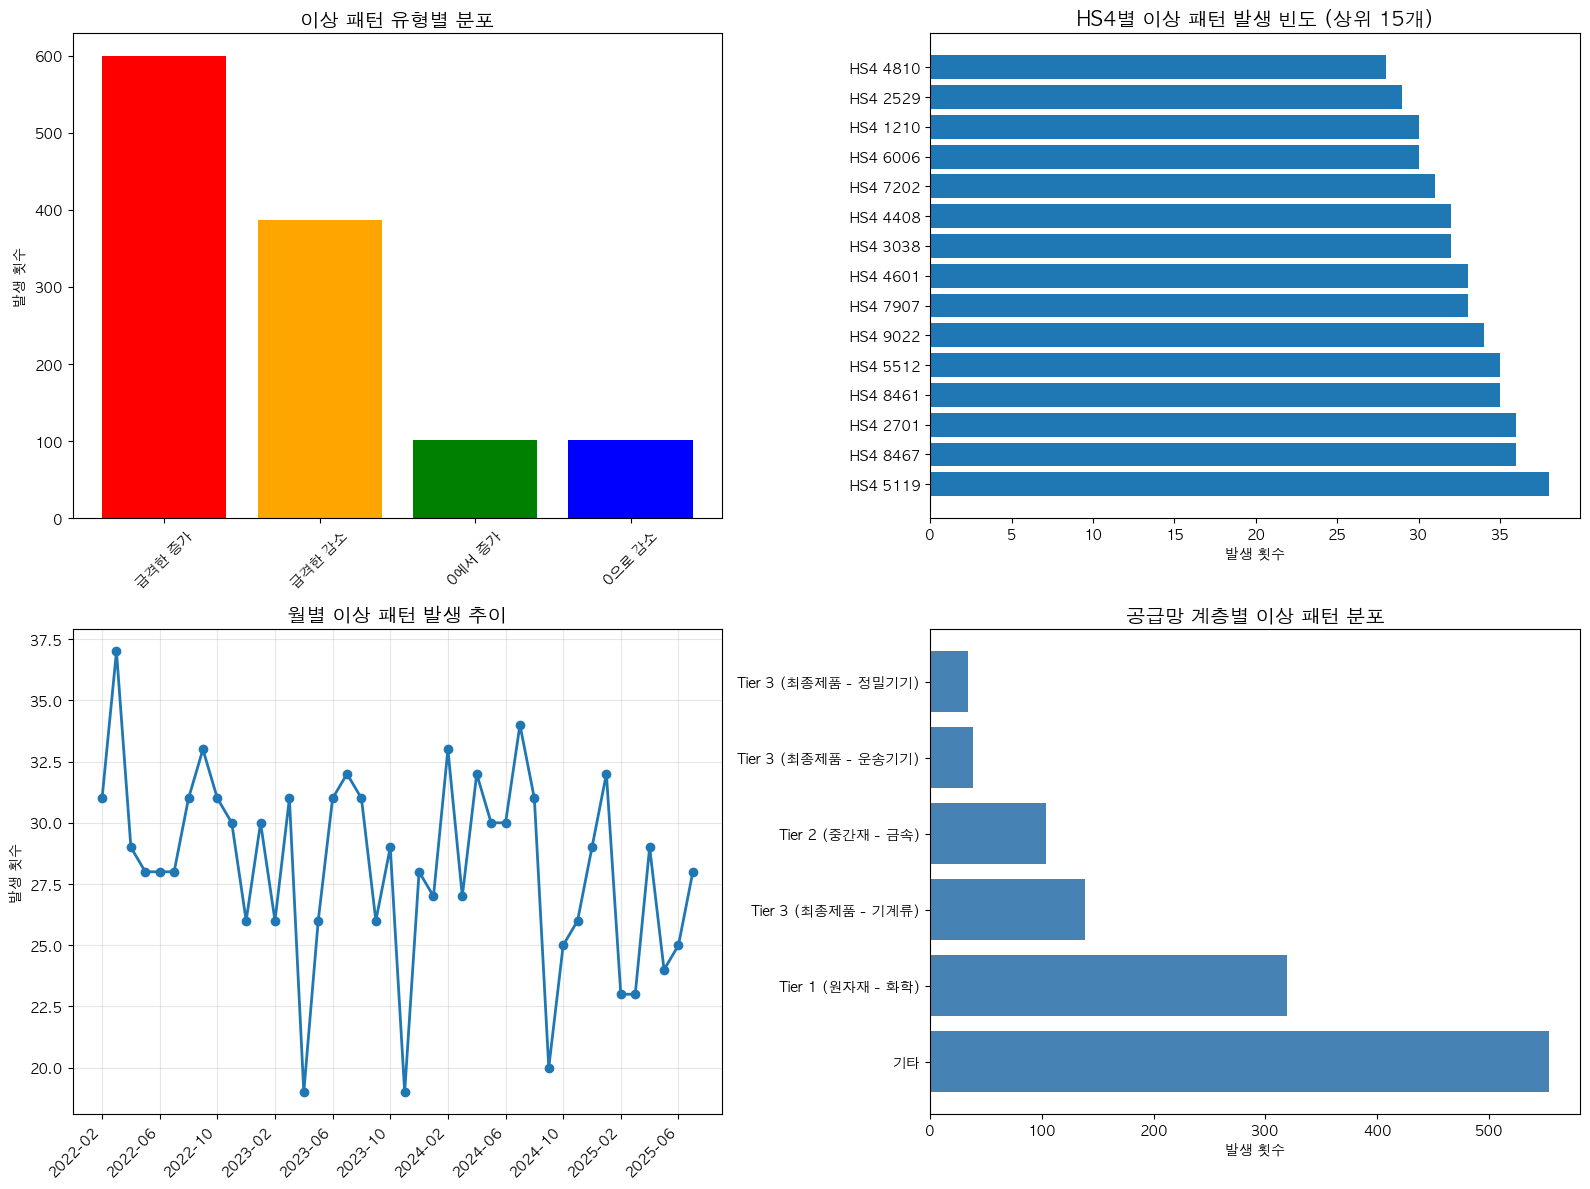

In [ ]:
# 이상 패턴 상세 분석 및 시각화
if len(anomalies_df) > 0:
    print("\n" + "="*70)
    print("이상 패턴 상세 분석")
    print("="*70)
    
    # 1. HS4별 이상 패턴 빈도
    print("\n[1] HS4별 이상 패턴 발생 빈도 (상위 20개):")
    hs4_anomaly_count = anomalies_df.groupby('hs4').size().sort_values(ascending=False)
    print(hs4_anomaly_count.head(20))
    
    # 2. 월별 이상 패턴 빈도
    print("\n[2] 월별 이상 패턴 발생 빈도:")
    anomalies_df['month_str'] = anomalies_df['month'].dt.strftime('%Y-%m')
    month_anomaly_count = anomalies_df.groupby('month_str').size().sort_values(ascending=False)
    print(month_anomaly_count)
    
    # 3. 공급망 계층별 이상 패턴
    print("\n[3] 공급망 계층별 이상 패턴 분포:")
    tier_anomaly = anomalies_df.groupby(['supply_chain_tier', 'change_type']).size().unstack(fill_value=0)
    print(tier_anomaly)
    
    # 4. 가장 큰 변화량 상위 20개
    print("\n[4] 가장 큰 변화량 상위 20개:")
    top_changes = anomalies_df.nlargest(20, 'change_amount')[['hs4', 'month_str', 'change_type', 
                                                               'prev_value', 'curr_value', 'change_amount', 
                                                               'change_ratio']]
    print(top_changes.to_string(index=False))
    
    # 5. 가장 큰 감소량 상위 20개
    print("\n[5] 가장 큰 감소량 상위 20개:")
    top_decreases = anomalies_df.nsmallest(20, 'change_amount')[['hs4', 'month_str', 'change_type', 
                                                                  'prev_value', 'curr_value', 'change_amount', 
                                                                  'change_ratio']]
    print(top_decreases.to_string(index=False))
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 이상 패턴 유형별 분포
    change_type_counts = anomalies_df['change_type'].value_counts()
    axes[0, 0].bar(change_type_counts.index, change_type_counts.values, color=['red', 'orange', 'green', 'blue'])
    axes[0, 0].set_title('이상 패턴 유형별 분포', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('발생 횟수')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. HS4별 이상 패턴 빈도 (상위 15개)
    top_hs4 = hs4_anomaly_count.head(15)
    axes[0, 1].barh(range(len(top_hs4)), top_hs4.values)
    axes[0, 1].set_yticks(range(len(top_hs4)))
    axes[0, 1].set_yticklabels([f'HS4 {hs4}' for hs4 in top_hs4.index])
    axes[0, 1].set_title('HS4별 이상 패턴 발생 빈도 (상위 15개)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('발생 횟수')
    
    # 3. 월별 이상 패턴 발생 추이
    month_anomaly_sorted = anomalies_df.groupby('month_str').size().sort_index()
    axes[1, 0].plot(range(len(month_anomaly_sorted)), month_anomaly_sorted.values, marker='o', linewidth=2)
    axes[1, 0].set_xticks(range(0, len(month_anomaly_sorted), max(1, len(month_anomaly_sorted)//10)))
    axes[1, 0].set_xticklabels([month_anomaly_sorted.index[i] for i in range(0, len(month_anomaly_sorted), max(1, len(month_anomaly_sorted)//10))], 
                              rotation=45, ha='right')
    axes[1, 0].set_title('월별 이상 패턴 발생 추이', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('발생 횟수')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 공급망 계층별 이상 패턴 분포
    tier_counts = anomalies_df['supply_chain_tier'].value_counts()
    axes[1, 1].barh(range(len(tier_counts)), tier_counts.values, color='steelblue')
    axes[1, 1].set_yticks(range(len(tier_counts)))
    axes[1, 1].set_yticklabels(tier_counts.index)
    axes[1, 1].set_title('공급망 계층별 이상 패턴 분포', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('발생 횟수')
    
    plt.tight_layout()
    plt.savefig('./images/hs4_monthly_anomalies.png', dpi=300, bbox_inches='tight')
    print("\n시각화 저장 완료: ./images/hs4_monthly_anomalies.png")
    plt.show()
    
else:
    print("시각화할 이상 패턴이 없습니다.")



이상 패턴이 많은 HS4 코드별 월별 추이 시각화



시각화 저장 완료: ./images/hs4_top_anomalies_timeline.png


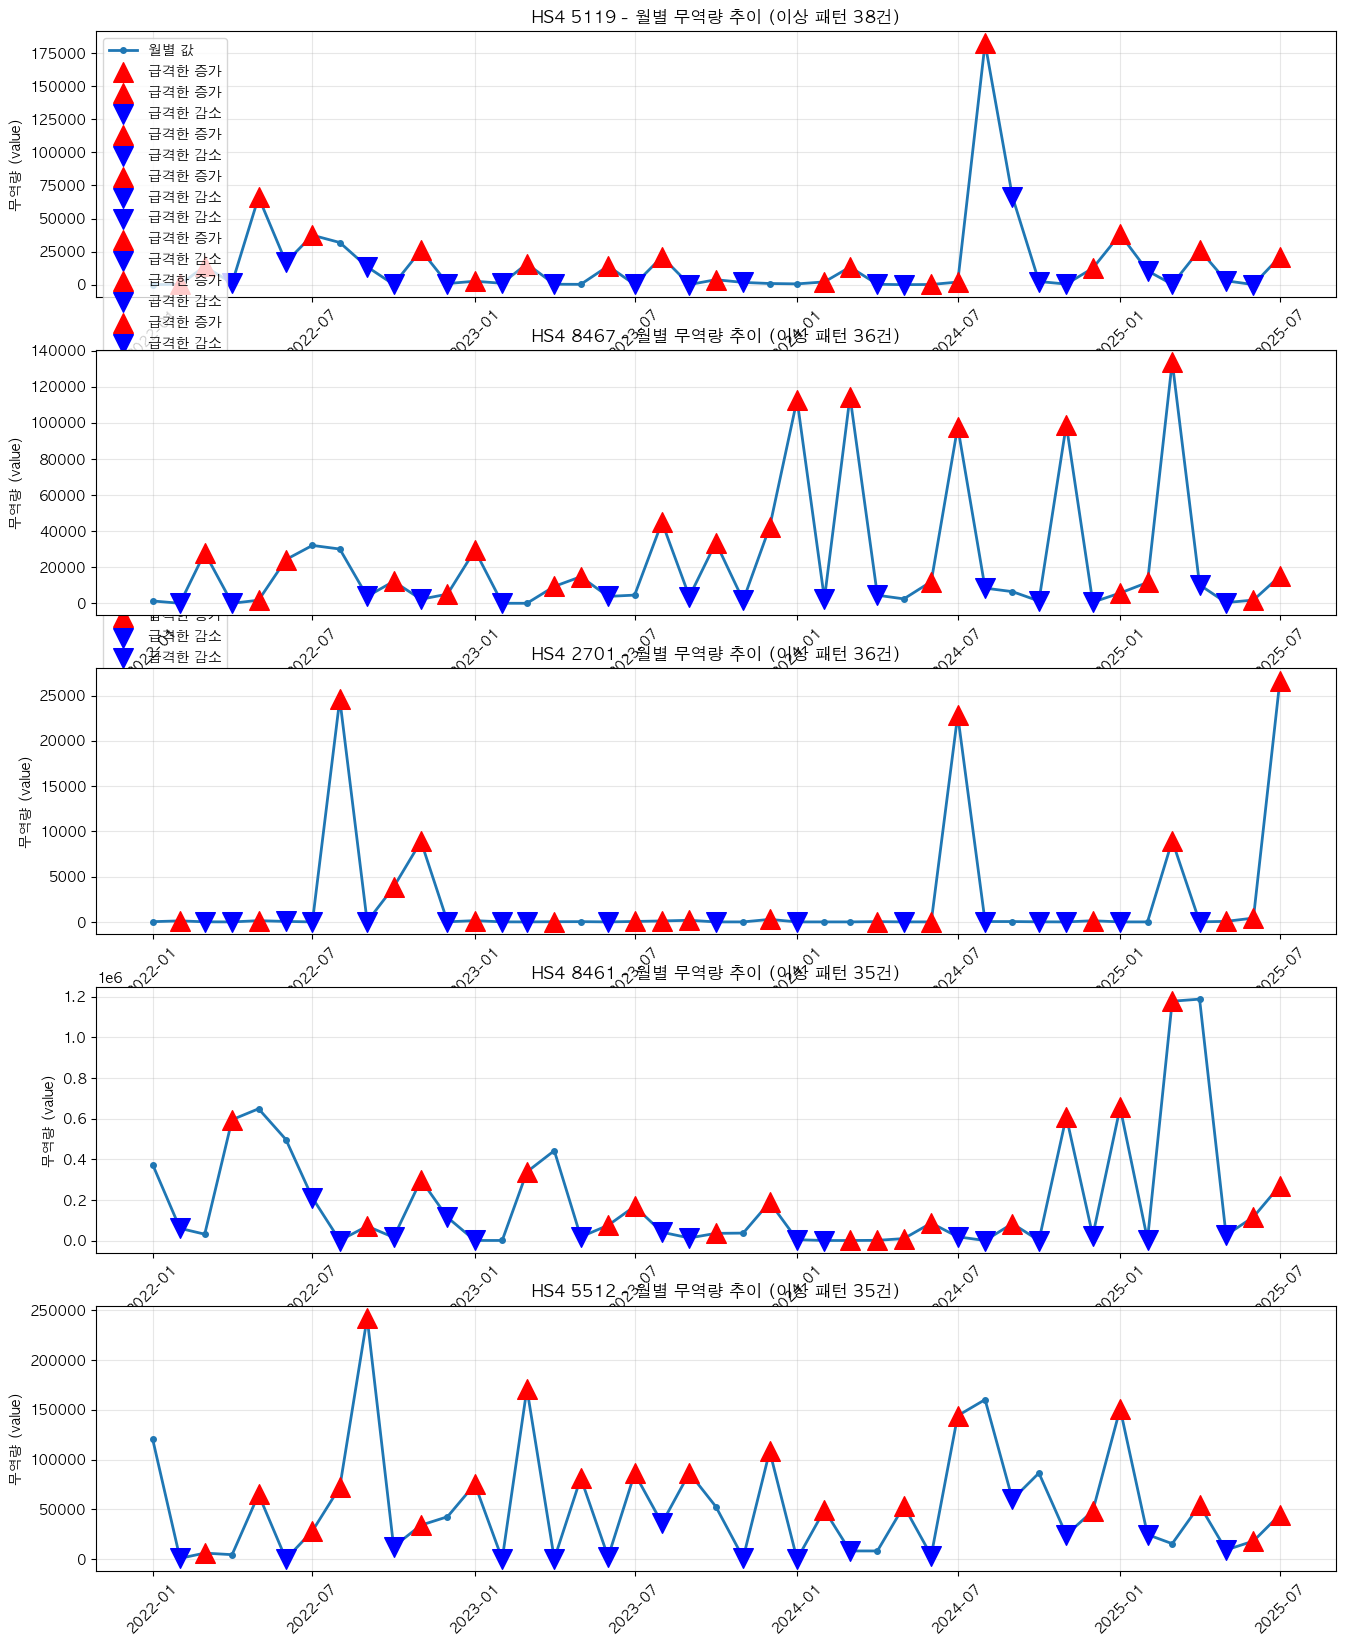


상위 5개 HS4 코드의 이상 패턴 상세:

[HS4 5119] - 38건의 이상 패턴
month_str change_type  prev_value  curr_value  change_ratio
  2022-02      0에서 증가         0.0       213.0           inf
  2022-03      급격한 증가       213.0     13792.0   6375.117371
  2022-04      급격한 감소     13792.0      1162.0    -91.574826
  2022-05      급격한 증가      1162.0     66157.0   5593.373494
  2022-06      급격한 감소     66157.0     16930.0    -74.409360
  2022-07      급격한 증가     16930.0     37392.0    120.862374
  2022-09      급격한 감소     31859.0     13473.0    -57.710537
  2022-10      급격한 감소     13473.0       186.0    -98.619461
  2022-11      급격한 증가       186.0     26079.0  13920.967742
  2022-12      급격한 감소     26079.0       839.0    -96.782852
  2023-01      급격한 증가       839.0      2594.0    209.177592
  2023-02      급격한 감소      2594.0      1033.0    -60.177332
  2023-03      급격한 증가      1033.0     15833.0   1432.720232
  2023-04      급격한 감소     15833.0       311.0    -98.035748
  2023-06      급격한 증가       245.0     14051.0   56

In [ ]:
# 특정 HS4 코드의 월별 추이 시각화 (이상 패턴이 많은 상위 5개)
if len(anomalies_df) > 0:
    print("\n" + "="*70)
    print("이상 패턴이 많은 HS4 코드별 월별 추이 시각화")
    print("="*70)
    
    top_anomaly_hs4 = hs4_anomaly_count.head(5).index.tolist()
    
    fig, axes = plt.subplots(len(top_anomaly_hs4), 1, figsize=(16, 4*len(top_anomaly_hs4)))
    if len(top_anomaly_hs4) == 1:
        axes = [axes]
    
    for idx, hs4 in enumerate(top_anomaly_hs4):
        hs4_values = hs4_pivot.loc[hs4].values
        hs4_months = hs4_pivot.columns
        
        # 이상 패턴이 발생한 월 표시
        hs4_anomalies = anomalies_df[anomalies_df['hs4'] == hs4]
        anomaly_months = hs4_anomalies['month'].tolist()
        
        axes[idx].plot(hs4_months, hs4_values, marker='o', linewidth=2, markersize=4, label='월별 값')
        
        # 이상 패턴 표시
        for _, row in hs4_anomalies.iterrows():
            month_idx = list(hs4_months).index(row['month'])
            if row['change_type'] == '급격한 증가' or row['change_type'] == '0에서 증가':
                axes[idx].scatter(row['month'], row['curr_value'], color='red', s=200, 
                                 marker='^', zorder=5, label='급격한 증가' if idx == 0 else '')
            elif row['change_type'] == '급격한 감소' or row['change_type'] == '0으로 감소':
                axes[idx].scatter(row['month'], row['curr_value'], color='blue', s=200, 
                                 marker='v', zorder=5, label='급격한 감소' if idx == 0 else '')
        
        axes[idx].set_title(f'HS4 {hs4} - 월별 무역량 추이 (이상 패턴 {hs4_anomaly_count[hs4]}건)', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('무역량 (value)', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
        if idx == 0:
            axes[idx].legend(loc='upper left')
    
    plt.tight_layout()
    plt.savefig('./images/hs4_top_anomalies_timeline.png', dpi=300, bbox_inches='tight')
    print("\n시각화 저장 완료: ./images/hs4_top_anomalies_timeline.png")
    plt.show()
    
    # 상세 정보 출력
    print("\n상위 5개 HS4 코드의 이상 패턴 상세:")
    for hs4 in top_anomaly_hs4:
        print(f"\n[HS4 {hs4}] - {hs4_anomaly_count[hs4]}건의 이상 패턴")
        hs4_detail = anomalies_df[anomalies_df['hs4'] == hs4][['month_str', 'change_type', 
                                                                'prev_value', 'curr_value', 
                                                                'change_ratio']].sort_values('month_str')
        print(hs4_detail.to_string(index=False))


## 4-2. HS4 코드 의미 및 품목 정보 분석


In [ ]:
print("\n" + "="*70)
print("[4-2단계] HS4 코드 의미 및 품목 정보 분석")
print("="*70)

# HS4 코드 분류 함수
def get_hs4_category(hs4):
    """HS4 코드를 기반으로 품목 카테고리 반환"""
    if 2800 <= hs4 < 2900:
        return "무기화학 제품"
    elif 2900 <= hs4 < 3000:
        return "유기화학 제품"
    elif 3000 <= hs4 < 3100:
        return "의약품"
    elif 3100 <= hs4 < 3200:
        return "비료"
    elif 3200 <= hs4 < 3300:
        return "염료, 착색제"
    elif 3300 <= hs4 < 3400:
        return "향료, 화장품"
    elif 3400 <= hs4 < 3500:
        return "비누, 세제"
    elif 3500 <= hs4 < 3600:
        return "알부민, 접착제"
    elif 3600 <= hs4 < 3700:
        return "폭약, 성냥"
    elif 3700 <= hs4 < 3800:
        return "사진용 재료"
    elif 3800 <= hs4 < 3900:
        return "기타 화학 제품"
    elif 7200 <= hs4 < 7300:
        return "철 및 철강"
    elif 7300 <= hs4 < 7400:
        return "구리 및 구리 제품"
    elif 7400 <= hs4 < 7500:
        return "니켈 및 니켈 제품"
    elif 7500 <= hs4 < 7600:
        return "알루미늄 및 알루미늄 제품"
    elif 7600 <= hs4 < 7800:
        return "기타 비철금속"
    elif 7800 <= hs4 < 8000:
        return "납, 아연, 주석"
    elif 8000 <= hs4 < 8100:
        return "기타 비금속"
    elif 8100 <= hs4 < 8200:
        return "니켈, 코발트"
    elif 8200 <= hs4 < 8300:
        return "기타 금속 제품"
    elif 8400 <= hs4 < 8500:
        return "원자로, 보일러, 기계류"
    elif 8500 <= hs4 < 8600:
        return "전기기기"
    elif 8600 <= hs4 < 8700:
        return "철도 및 궤도 차량"
    elif 8700 <= hs4 < 8800:
        return "자동차"
    elif 8800 <= hs4 < 8900:
        return "선박, 항공기"
    elif 9000 <= hs4 < 9100:
        return "광학기기"
    elif 9100 <= hs4 < 9200:
        return "시계"
    elif 9200 <= hs4 < 9300:
        return "악기"
    elif 1200 <= hs4 < 1300:
        return "유지종자 및 과실"
    elif 2700 <= hs4 < 2800:
        return "광물성 연료"
    elif 3800 <= hs4 < 3900:
        return "기타 화학 제품"
    elif 4400 <= hs4 < 4500:
        return "목재"
    elif 4600 <= hs4 < 4700:
        return "목재 제품"
    elif 4800 <= hs4 < 4900:
        return "펄프, 종이"
    elif 5000 <= hs4 < 5100:
        return "견사"
    elif 5100 <= hs4 < 5200:
        return "면사"
    elif 5200 <= hs4 < 5300:
        return "기타 직물"
    elif 5500 <= hs4 < 5600:
        return "화학섬유"
    elif 7900 <= hs4 < 8000:
        return "아연"
    else:
        return "기타"

# HS4 코드별 상세 설명 (주요 코드)
hs4_descriptions = {
    8461: "절삭가공용 공작기계",
    8467: "기타 공작기계",
    8479: "기타 기계류",
    8501: "전기모터 및 발전기",
    8505: "전자석, 영구자석 및 그 부품",
    8527: "무선통신용 기기",
    8102: "니켈",
    8105: "코발트",
    7202: "철합금",
    7207: "철강재",
    2805: "니켈",
    2811: "기타 무기화합물",
    3824: "기타 화학제품",
    2701: "석탄",
    3102: "질소비료",
    3105: "기타 비료",
    4408: "합판",
    4601: "대나무 제품",
    4802: "펄프",
    5001: "견사",
    5101: "면사",
    5119: "기타 직물",
    5512: "합성섬유",
    7907: "아연",
    9022: "X선 장치",
    1210: "유지종자",
    3038: "어류",
    4601: "대나무 제품",
    4408: "합판",
}

# 이상 패턴이 많은 상위 HS4 코드들의 상세 정보
if len(anomalies_df) > 0:
    top_anomaly_hs4_list = hs4_anomaly_count.head(20).index.tolist()
    
    print(f"\n이상 패턴이 많은 상위 20개 HS4 코드 상세 정보:")
    print("="*70)
    
    hs4_detail_info = []
    
    for hs4 in top_anomaly_hs4_list:
        # 해당 HS4 코드의 품목 정보
        hs4_items = train[train['hs4'] == hs4]
        item_ids = hs4_items['item_id'].unique()
        total_value = hs4_items['value'].sum()
        total_weight = hs4_items['weight'].sum()
        transaction_count = len(hs4_items)
        avg_value = hs4_items['value'].mean()
        
        # HS4 코드 설명
        category = get_hs4_category(hs4)
        description = hs4_descriptions.get(hs4, f"{category} (상세 미정)")
        supply_tier = get_supply_chain_tier(hs4)
        anomaly_count = hs4_anomaly_count[hs4]
        
        hs4_detail_info.append({
            'hs4': hs4,
            'category': category,
            'description': description,
            'supply_chain_tier': supply_tier,
            'anomaly_count': anomaly_count,
            'item_count': len(item_ids),
            'total_value': total_value,
            'total_weight': total_weight,
            'transaction_count': transaction_count,
            'avg_value': avg_value,
            'item_ids': list(item_ids)
        })
        
        print(f"\n[HS4 {hs4}] {description}")
        print(f"  카테고리: {category}")
        print(f"  공급망 계층: {supply_tier}")
        print(f"  이상 패턴 발생: {anomaly_count}건")
        print(f"  품목 수: {len(item_ids)}개")
        print(f"  총 무역량: {total_value:,.0f}")
        print(f"  총 무게: {total_weight:,.0f}")
        print(f"  거래 건수: {transaction_count:,}건")
        print(f"  평균 무역량: {avg_value:,.0f}")
        print(f"  품목 ID: {list(item_ids)[:5]}..." if len(item_ids) > 5 else f"  품목 ID: {list(item_ids)}")
    
    hs4_detail_df = pd.DataFrame(hs4_detail_info)
    
    # 결과 저장
    hs4_detail_export = hs4_detail_df[['hs4', 'category', 'description', 'supply_chain_tier', 
                                       'anomaly_count', 'item_count', 'total_value', 
                                       'total_weight', 'transaction_count', 'avg_value']].copy()
    hs4_detail_export.to_csv('./results/hs4_anomaly_detail_info.csv', index=False, encoding='utf-8-sig')
    print(f"\n저장 완료: ./results/hs4_anomaly_detail_info.csv")



[4-2단계] HS4 코드 의미 및 품목 정보 분석

이상 패턴이 많은 상위 20개 HS4 코드 상세 정보:

[HS4 5119] 기타 직물
  카테고리: 면사
  공급망 계층: 기타
  이상 패턴 발생: 38건
  품목 수: 1개
  총 무역량: 651,539
  총 무게: 153
  거래 건수: 96건
  평균 무역량: 6,787
  품목 ID: ['JSLXRQOK']

[HS4 8467] 기타 공작기계
  카테고리: 원자로, 보일러, 기계류
  공급망 계층: Tier 3 (최종제품 - 기계류)
  이상 패턴 발생: 36건
  품목 수: 1개
  총 무역량: 969,367
  총 무게: 25,499
  거래 건수: 113건
  평균 무역량: 8,578
  품목 ID: ['KAGJCHMR']

[HS4 2701] 석탄
  카테고리: 광물성 연료
  공급망 계층: 기타
  이상 패턴 발생: 36건
  품목 수: 1개
  총 무역량: 97,723
  총 무게: 105,615
  거래 건수: 62건
  평균 무역량: 1,576
  품목 ID: ['FWUCPMMW']

[HS4 8461] 절삭가공용 공작기계
  카테고리: 원자로, 보일러, 기계류
  공급망 계층: Tier 3 (최종제품 - 기계류)
  이상 패턴 발생: 35건
  품목 수: 1개
  총 무역량: 8,540,033
  총 무게: 586,921
  거래 건수: 105건
  평균 무역량: 81,334
  품목 ID: ['ZCELVYQU']

[HS4 5512] 합성섬유
  카테고리: 화학섬유
  공급망 계층: 기타
  이상 패턴 발생: 35건
  품목 수: 1개
  총 무역량: 2,294,981
  총 무게: 115,214
  거래 건수: 114건
  평균 무역량: 20,131
  품목 ID: ['WHPUAOID']

[HS4 9022] X선 장치
  카테고리: 광학기기
  공급망 계층: Tier 3 (최종제품 - 정밀기기)
  이상 패턴 발생: 34건
  품목 수: 1개
  총 무역량: 541,289


HS4 코드별 상세 정보 시각화



시각화 저장 완료: ./images/hs4_anomaly_detailed_analysis.png


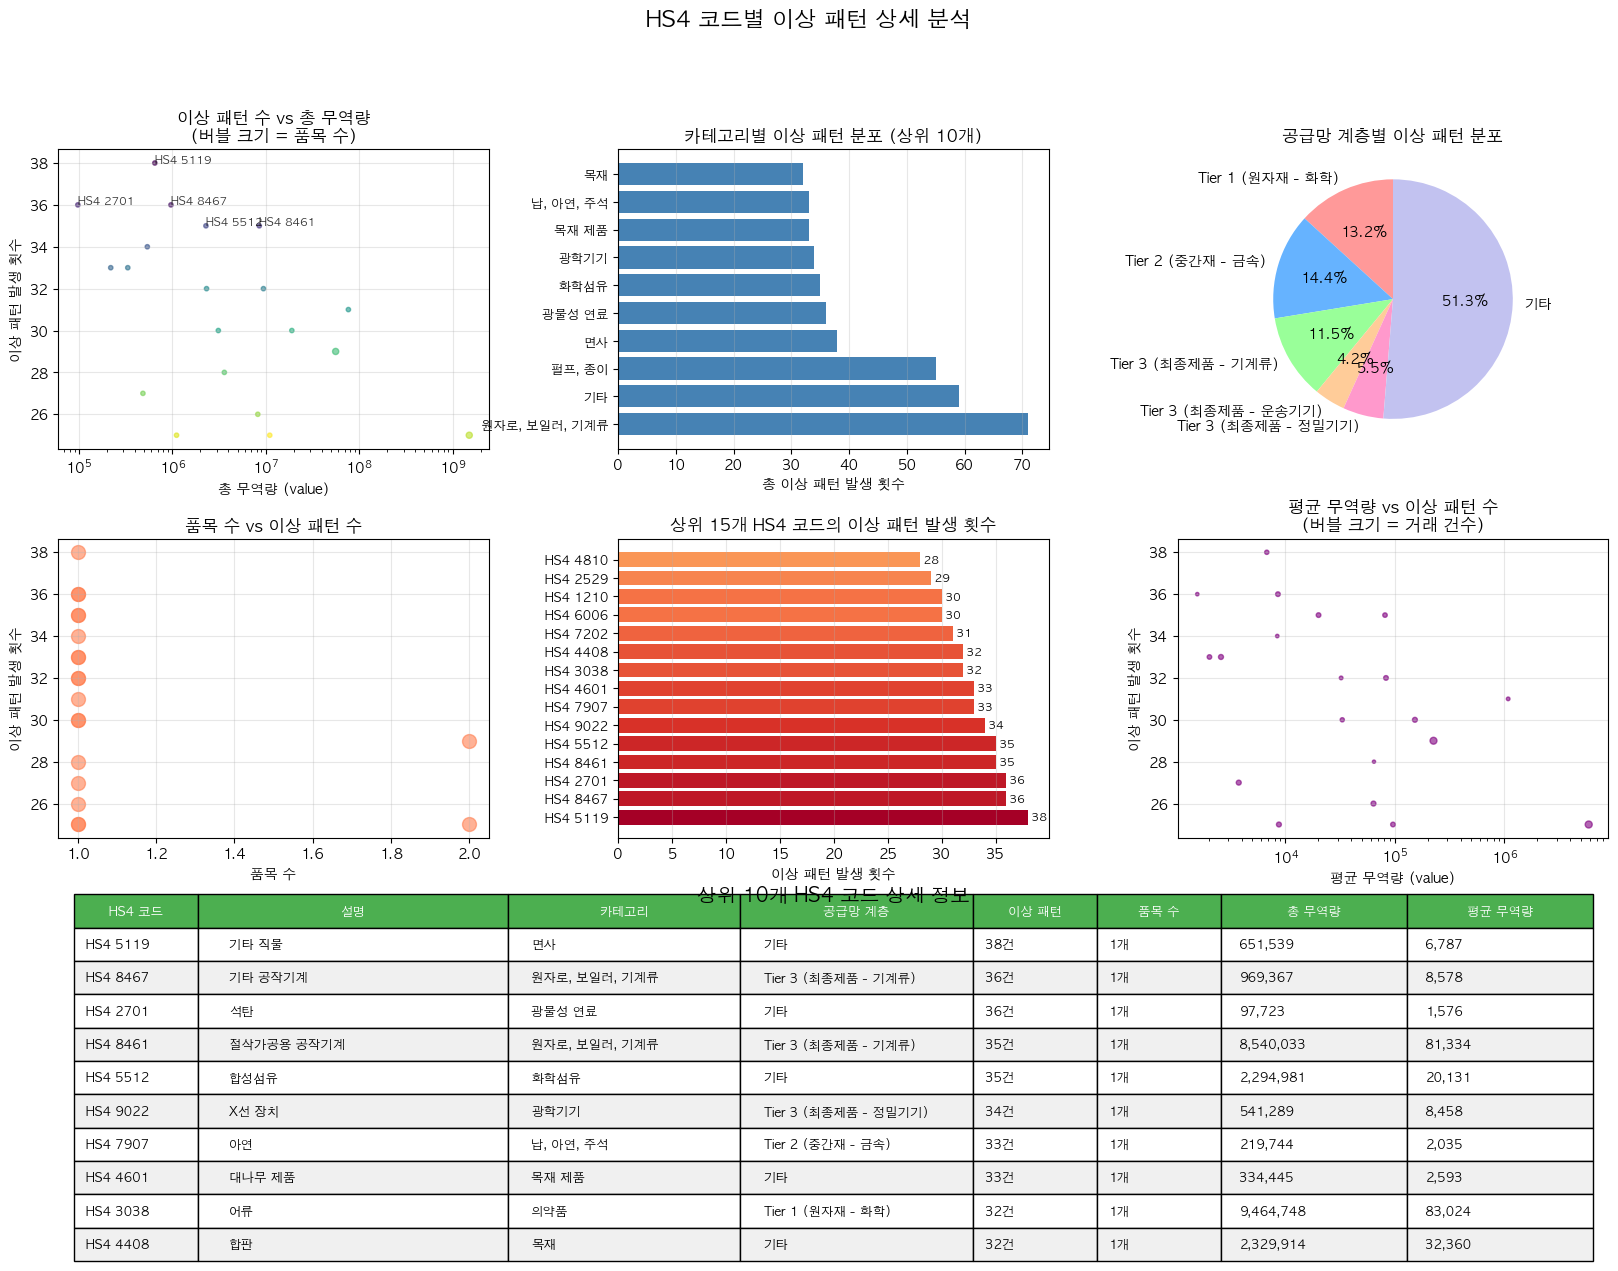

In [ ]:
# HS4 코드별 상세 정보 시각화
if len(anomalies_df) > 0 and 'hs4_detail_df' in locals():
    print("\n" + "="*70)
    print("HS4 코드별 상세 정보 시각화")
    print("="*70)
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. 이상 패턴 수 vs 총 무역량 (산점도)
    ax1 = fig.add_subplot(gs[0, 0])
    scatter = ax1.scatter(hs4_detail_df['total_value'], hs4_detail_df['anomaly_count'], 
                          s=hs4_detail_df['item_count']*10, alpha=0.6, 
                          c=range(len(hs4_detail_df)), cmap='viridis')
    ax1.set_xlabel('총 무역량 (value)', fontsize=10)
    ax1.set_ylabel('이상 패턴 발생 횟수', fontsize=10)
    ax1.set_title('이상 패턴 수 vs 총 무역량\n(버블 크기 = 품목 수)', fontsize=12, fontweight='bold')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    
    # 상위 5개 HS4 코드 라벨 추가
    top5 = hs4_detail_df.nlargest(5, 'anomaly_count')
    for _, row in top5.iterrows():
        ax1.annotate(f'HS4 {int(row["hs4"])}', 
                    (row['total_value'], row['anomaly_count']),
                    fontsize=8, alpha=0.8)
    
    # 2. 카테고리별 이상 패턴 분포
    ax2 = fig.add_subplot(gs[0, 1])
    category_counts = hs4_detail_df.groupby('category')['anomaly_count'].sum().sort_values(ascending=False).head(10)
    ax2.barh(range(len(category_counts)), category_counts.values, color='steelblue')
    ax2.set_yticks(range(len(category_counts)))
    ax2.set_yticklabels(category_counts.index, fontsize=9)
    ax2.set_xlabel('총 이상 패턴 발생 횟수', fontsize=10)
    ax2.set_title('카테고리별 이상 패턴 분포 (상위 10개)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # 3. 공급망 계층별 이상 패턴
    ax3 = fig.add_subplot(gs[0, 2])
    tier_counts = hs4_detail_df.groupby('supply_chain_tier')['anomaly_count'].sum()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0']
    ax3.pie(tier_counts.values, labels=tier_counts.index, autopct='%1.1f%%', 
           startangle=90, colors=colors[:len(tier_counts)])
    ax3.set_title('공급망 계층별 이상 패턴 분포', fontsize=12, fontweight='bold')
    
    # 4. HS4별 품목 수 vs 이상 패턴 수
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.scatter(hs4_detail_df['item_count'], hs4_detail_df['anomaly_count'], 
               alpha=0.6, s=100, color='coral')
    ax4.set_xlabel('품목 수', fontsize=10)
    ax4.set_ylabel('이상 패턴 발생 횟수', fontsize=10)
    ax4.set_title('품목 수 vs 이상 패턴 수', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. 상위 15개 HS4 코드의 이상 패턴 수 (막대 그래프)
    ax5 = fig.add_subplot(gs[1, 1])
    top15 = hs4_detail_df.nlargest(15, 'anomaly_count')
    bars = ax5.barh(range(len(top15)), top15['anomaly_count'].values, 
                    color=plt.cm.RdYlGn_r(top15['anomaly_count'].values / top15['anomaly_count'].max()))
    ax5.set_yticks(range(len(top15)))
    ax5.set_yticklabels([f"HS4 {int(hs4)}" for hs4 in top15['hs4']], fontsize=9)
    ax5.set_xlabel('이상 패턴 발생 횟수', fontsize=10)
    ax5.set_title('상위 15개 HS4 코드의 이상 패턴 발생 횟수', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 값 표시
    for i, (idx, row) in enumerate(top15.iterrows()):
        ax5.text(row['anomaly_count'], i, f" {int(row['anomaly_count'])}", 
                va='center', fontsize=8)
    
    # 6. HS4별 평균 무역량 vs 이상 패턴 수
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.scatter(hs4_detail_df['avg_value'], hs4_detail_df['anomaly_count'], 
               alpha=0.6, s=hs4_detail_df['transaction_count']/10, color='purple')
    ax6.set_xlabel('평균 무역량 (value)', fontsize=10)
    ax6.set_ylabel('이상 패턴 발생 횟수', fontsize=10)
    ax6.set_title('평균 무역량 vs 이상 패턴 수\n(버블 크기 = 거래 건수)', fontsize=12, fontweight='bold')
    ax6.set_xscale('log')
    ax6.grid(True, alpha=0.3)
    
    # 7. 상위 10개 HS4 코드의 상세 정보 테이블
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('tight')
    ax7.axis('off')
    
    # 테이블 데이터 준비
    table_data = []
    top10 = hs4_detail_df.nlargest(10, 'anomaly_count')
    for _, row in top10.iterrows():
        table_data.append([
            f"HS4 {int(row['hs4'])}",
            row['description'][:30] + '...' if len(row['description']) > 30 else row['description'],
            row['category'][:20] + '...' if len(row['category']) > 20 else row['category'],
            row['supply_chain_tier'][:25] + '...' if len(row['supply_chain_tier']) > 25 else row['supply_chain_tier'],
            f"{int(row['anomaly_count'])}건",
            f"{int(row['item_count'])}개",
            f"{row['total_value']:,.0f}",
            f"{row['avg_value']:,.0f}"
        ])
    
    table = ax7.table(cellText=table_data,
                     colLabels=['HS4 코드', '설명', '카테고리', '공급망 계층', 
                               '이상 패턴', '품목 수', '총 무역량', '평균 무역량'],
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.08, 0.20, 0.15, 0.15, 0.08, 0.08, 0.12, 0.12])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # 헤더 스타일
    for i in range(8):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 행별 색상
    for i in range(1, len(table_data) + 1):
        for j in range(8):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
    
    ax7.set_title('상위 10개 HS4 코드 상세 정보', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('HS4 코드별 이상 패턴 상세 분석', fontsize=16, fontweight='bold', y=0.98)
    plt.savefig('./images/hs4_anomaly_detailed_analysis.png', dpi=300, bbox_inches='tight')
    print("\n시각화 저장 완료: ./images/hs4_anomaly_detailed_analysis.png")
    plt.show()



[4-3단계] 월별 HS4 코드 이상 패턴 시각화

월별 × HS4 코드별 이상 패턴 히트맵 생성 중...


저장 완료: ./images/hs4_monthly_anomalies_heatmap.png


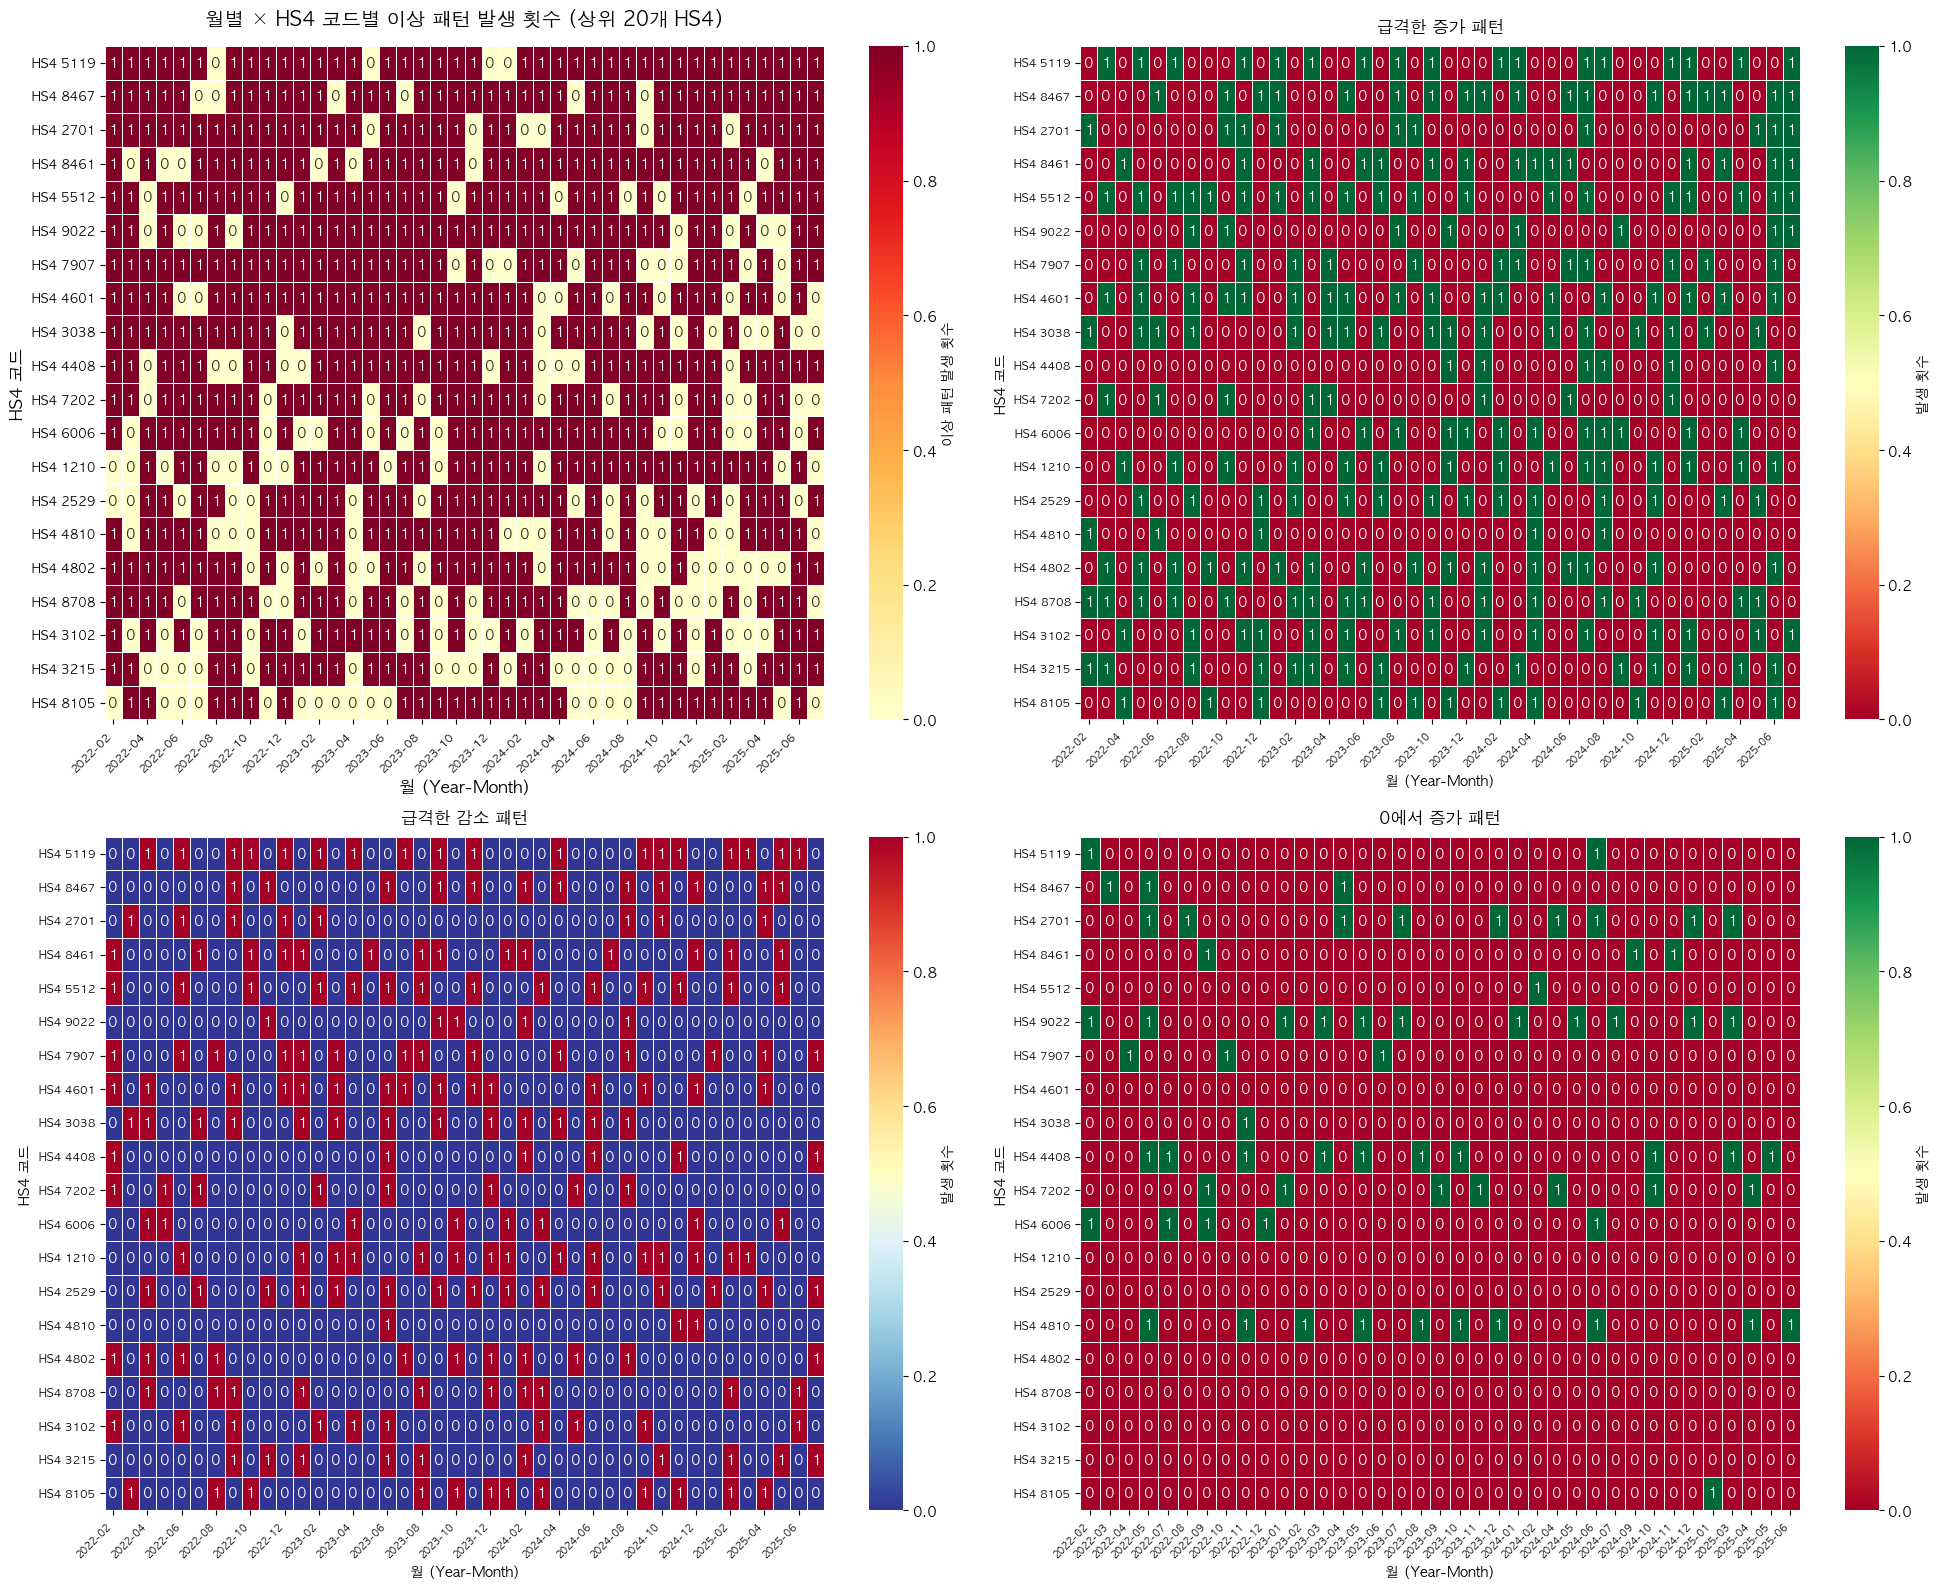


월별 이상 패턴 요약:

2022-02: 17개 HS4 코드에서 이상 패턴 발생
  - 급격한 감소: 8건
  - 급격한 증가: 5건
  - 0에서 증가: 3건
  - 0으로 감소: 1건

2022-03: 14개 HS4 코드에서 이상 패턴 발생
  - 급격한 증가: 7건
  - 0으로 감소: 3건
  - 급격한 감소: 3건
  - 0에서 증가: 1건

2022-04: 15개 HS4 코드에서 이상 패턴 발생
  - 급격한 감소: 7건
  - 급격한 증가: 4건
  - 0으로 감소: 3건
  - 0에서 증가: 1건

2022-05: 15개 HS4 코드에서 이상 패턴 발생
  - 급격한 증가: 8건
  - 0에서 증가: 5건
  - 급격한 감소: 2건

2022-06: 13개 HS4 코드에서 이상 패턴 발생
  - 급격한 감소: 7건
  - 급격한 증가: 4건
  - 0으로 감소: 2건

2022-07: 14개 HS4 코드에서 이상 패턴 발생
  - 급격한 증가: 6건
  - 급격한 감소: 4건
  - 0으로 감소: 2건
  - 0에서 증가: 2건

2022-08: 15개 HS4 코드에서 이상 패턴 발생
  - 급격한 증가: 7건
  - 급격한 감소: 4건
  - 0으로 감소: 3건
  - 0에서 증가: 1건

2022-09: 15개 HS4 코드에서 이상 패턴 발생
  - 급격한 감소: 8건
  - 급격한 증가: 3건
  - 0에서 증가: 3건
  - 0으로 감소: 1건

2022-10: 15개 HS4 코드에서 이상 패턴 발생
  - 급격한 증가: 7건
  - 급격한 감소: 4건
  - 0으로 감소: 3건
  - 0에서 증가: 1건

2022-11: 15개 HS4 코드에서 이상 패턴 발생
  - 급격한 증가: 8건
  - 급격한 감소: 4건
  - 0에서 증가: 3건

2022-12: 14개 HS4 코드에서 이상 패턴 발생
  - 급격한 증가: 6건
  - 급격한 감소: 5건
  - 0으로 감소: 2건
  - 0에서 증가: 1건

2023-01: 16개 HS4 코

In [ ]:
print("\n" + "="*70)
print("[4-3단계] 월별 HS4 코드 이상 패턴 시각화")
print("="*70)

if len(anomalies_df) > 0:
    # 월별 × HS4 코드별 이상 패턴 히트맵 데이터 준비
    anomalies_df['month_str'] = anomalies_df['month'].dt.strftime('%Y-%m')
    
    # 이상 패턴 유형별로 분리하여 히트맵 생성
    print("\n월별 × HS4 코드별 이상 패턴 히트맵 생성 중...")
    
    # 상위 20개 HS4 코드 선택
    top_hs4_codes = hs4_anomaly_count.head(20).index.tolist()
    top_anomalies = anomalies_df[anomalies_df['hs4'].isin(top_hs4_codes)].copy()
    
    # 월별 정렬
    top_anomalies = top_anomalies.sort_values('month_str')
    
    # 히트맵 1: 월별 × HS4 코드별 이상 패턴 발생 횟수
    heatmap_data = top_anomalies.groupby(['month_str', 'hs4']).size().unstack(fill_value=0)
    
    # HS4 코드를 이상 패턴 수가 많은 순으로 정렬
    heatmap_data = heatmap_data[top_hs4_codes]
    
    print(f"\n히트맵 데이터 통계:")
    print(f"  - 최소 발생 횟수: {heatmap_data.min().min()}")
    print(f"  - 최대 발생 횟수: {heatmap_data.max().max()}")
    print(f"  - 평균 발생 횟수: {heatmap_data.mean().mean():.2f}")
    print(f"  - 0회 발생 셀: {(heatmap_data == 0).sum().sum()}개")
    print(f"  - 1회 발생 셀: {(heatmap_data == 1).sum().sum()}개")
    print(f"  - 2회 이상 발생 셀: {(heatmap_data >= 2).sum().sum()}개")
    print(f"\n※ 히트맵의 숫자는 '해당 월에 해당 HS4 코드에서 이상 패턴이 발생한 횟수'를 의미합니다.")
    print(f"  - 0: 해당 월에 이상 패턴이 발생하지 않음")
    print(f"  - 1 이상: 해당 월에 이상 패턴이 발생한 횟수 (1회, 2회, 3회 등)")
    
    # 시각화 1: 월별 × HS4 코드별 이상 패턴 발생 횟수 히트맵
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 히트맵 1: 전체 이상 패턴 발생 횟수 (색상 강도로 구분)
    sns.heatmap(heatmap_data.T, annot=True, fmt='d', cmap='YlOrRd', 
                cbar_kws={'label': '이상 패턴 발생 횟수'}, 
                linewidths=0.5, ax=axes[0, 0], vmin=0, vmax=max(3, heatmap_data.max().max()))
    axes[0, 0].set_title('월별 × HS4 코드별 이상 패턴 발생 횟수 (상위 20개 HS4)', 
                        fontsize=14, fontweight='bold', pad=15)
    axes[0, 0].set_xlabel('월 (Year-Month)', fontsize=12)
    axes[0, 0].set_ylabel('HS4 코드', fontsize=12)
    axes[0, 0].set_yticklabels([f'HS4 {int(hs4)}' for hs4 in heatmap_data.columns], 
                               rotation=0, fontsize=9)
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    
    # 히트맵 2: 이상 패턴 유형별 분리
    for idx, change_type in enumerate(['급격한 증가', '급격한 감소', '0에서 증가', '0으로 감소']):
        type_data = top_anomalies[top_anomalies['change_type'] == change_type]
        if len(type_data) > 0:
            type_heatmap = type_data.groupby(['month_str', 'hs4']).size().unstack(fill_value=0)
            type_heatmap = type_heatmap.reindex(columns=top_hs4_codes, fill_value=0)
            
            row = (idx + 1) // 2
            col = (idx + 1) % 2
            
            if row < 2 and col < 2:
                max_val = max(2, type_heatmap.max().max()) if type_heatmap.max().max() > 0 else 1
                sns.heatmap(type_heatmap.T, annot=True, fmt='d', 
                           cmap='RdYlGn' if '증가' in change_type else 'RdYlBu_r',
                           cbar_kws={'label': '발생 횟수'}, linewidths=0.5, ax=axes[row, col],
                           vmin=0, vmax=max_val)
                axes[row, col].set_title(f'{change_type} 패턴\n(숫자 = 해당 월 발생 횟수)', 
                                        fontsize=12, fontweight='bold', pad=10)
                axes[row, col].set_xlabel('월 (Year-Month)', fontsize=10)
                axes[row, col].set_ylabel('HS4 코드', fontsize=10)
                axes[row, col].set_yticklabels([f'HS4 {int(hs4)}' for hs4 in type_heatmap.columns], 
                                             rotation=0, fontsize=8)
                axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), 
                                               rotation=45, ha='right', fontsize=7)
    
    plt.tight_layout()
    plt.savefig('./images/hs4_monthly_anomalies_heatmap.png', dpi=300, bbox_inches='tight')
    print("저장 완료: ./images/hs4_monthly_anomalies_heatmap.png")
    plt.show()
    
    # 월별 이상 패턴 요약 통계
    print("\n월별 이상 패턴 요약:")
    monthly_summary = top_anomalies.groupby('month_str').agg({
        'hs4': 'nunique',
        'change_type': lambda x: x.value_counts().to_dict()
    }).reset_index()
    monthly_summary.columns = ['month', 'unique_hs4_count', 'change_type_counts']
    
    for _, row in monthly_summary.iterrows():
        print(f"\n{row['month']}: {row['unique_hs4_count']}개 HS4 코드에서 이상 패턴 발생")
        if isinstance(row['change_type_counts'], dict):
            for change_type, count in row['change_type_counts'].items():
                print(f"  - {change_type}: {count}건")



월별 × HS4 코드별 이상 패턴 타임라인 시각화


저장 완료: ./images/hs4_monthly_anomalies_timeline.png


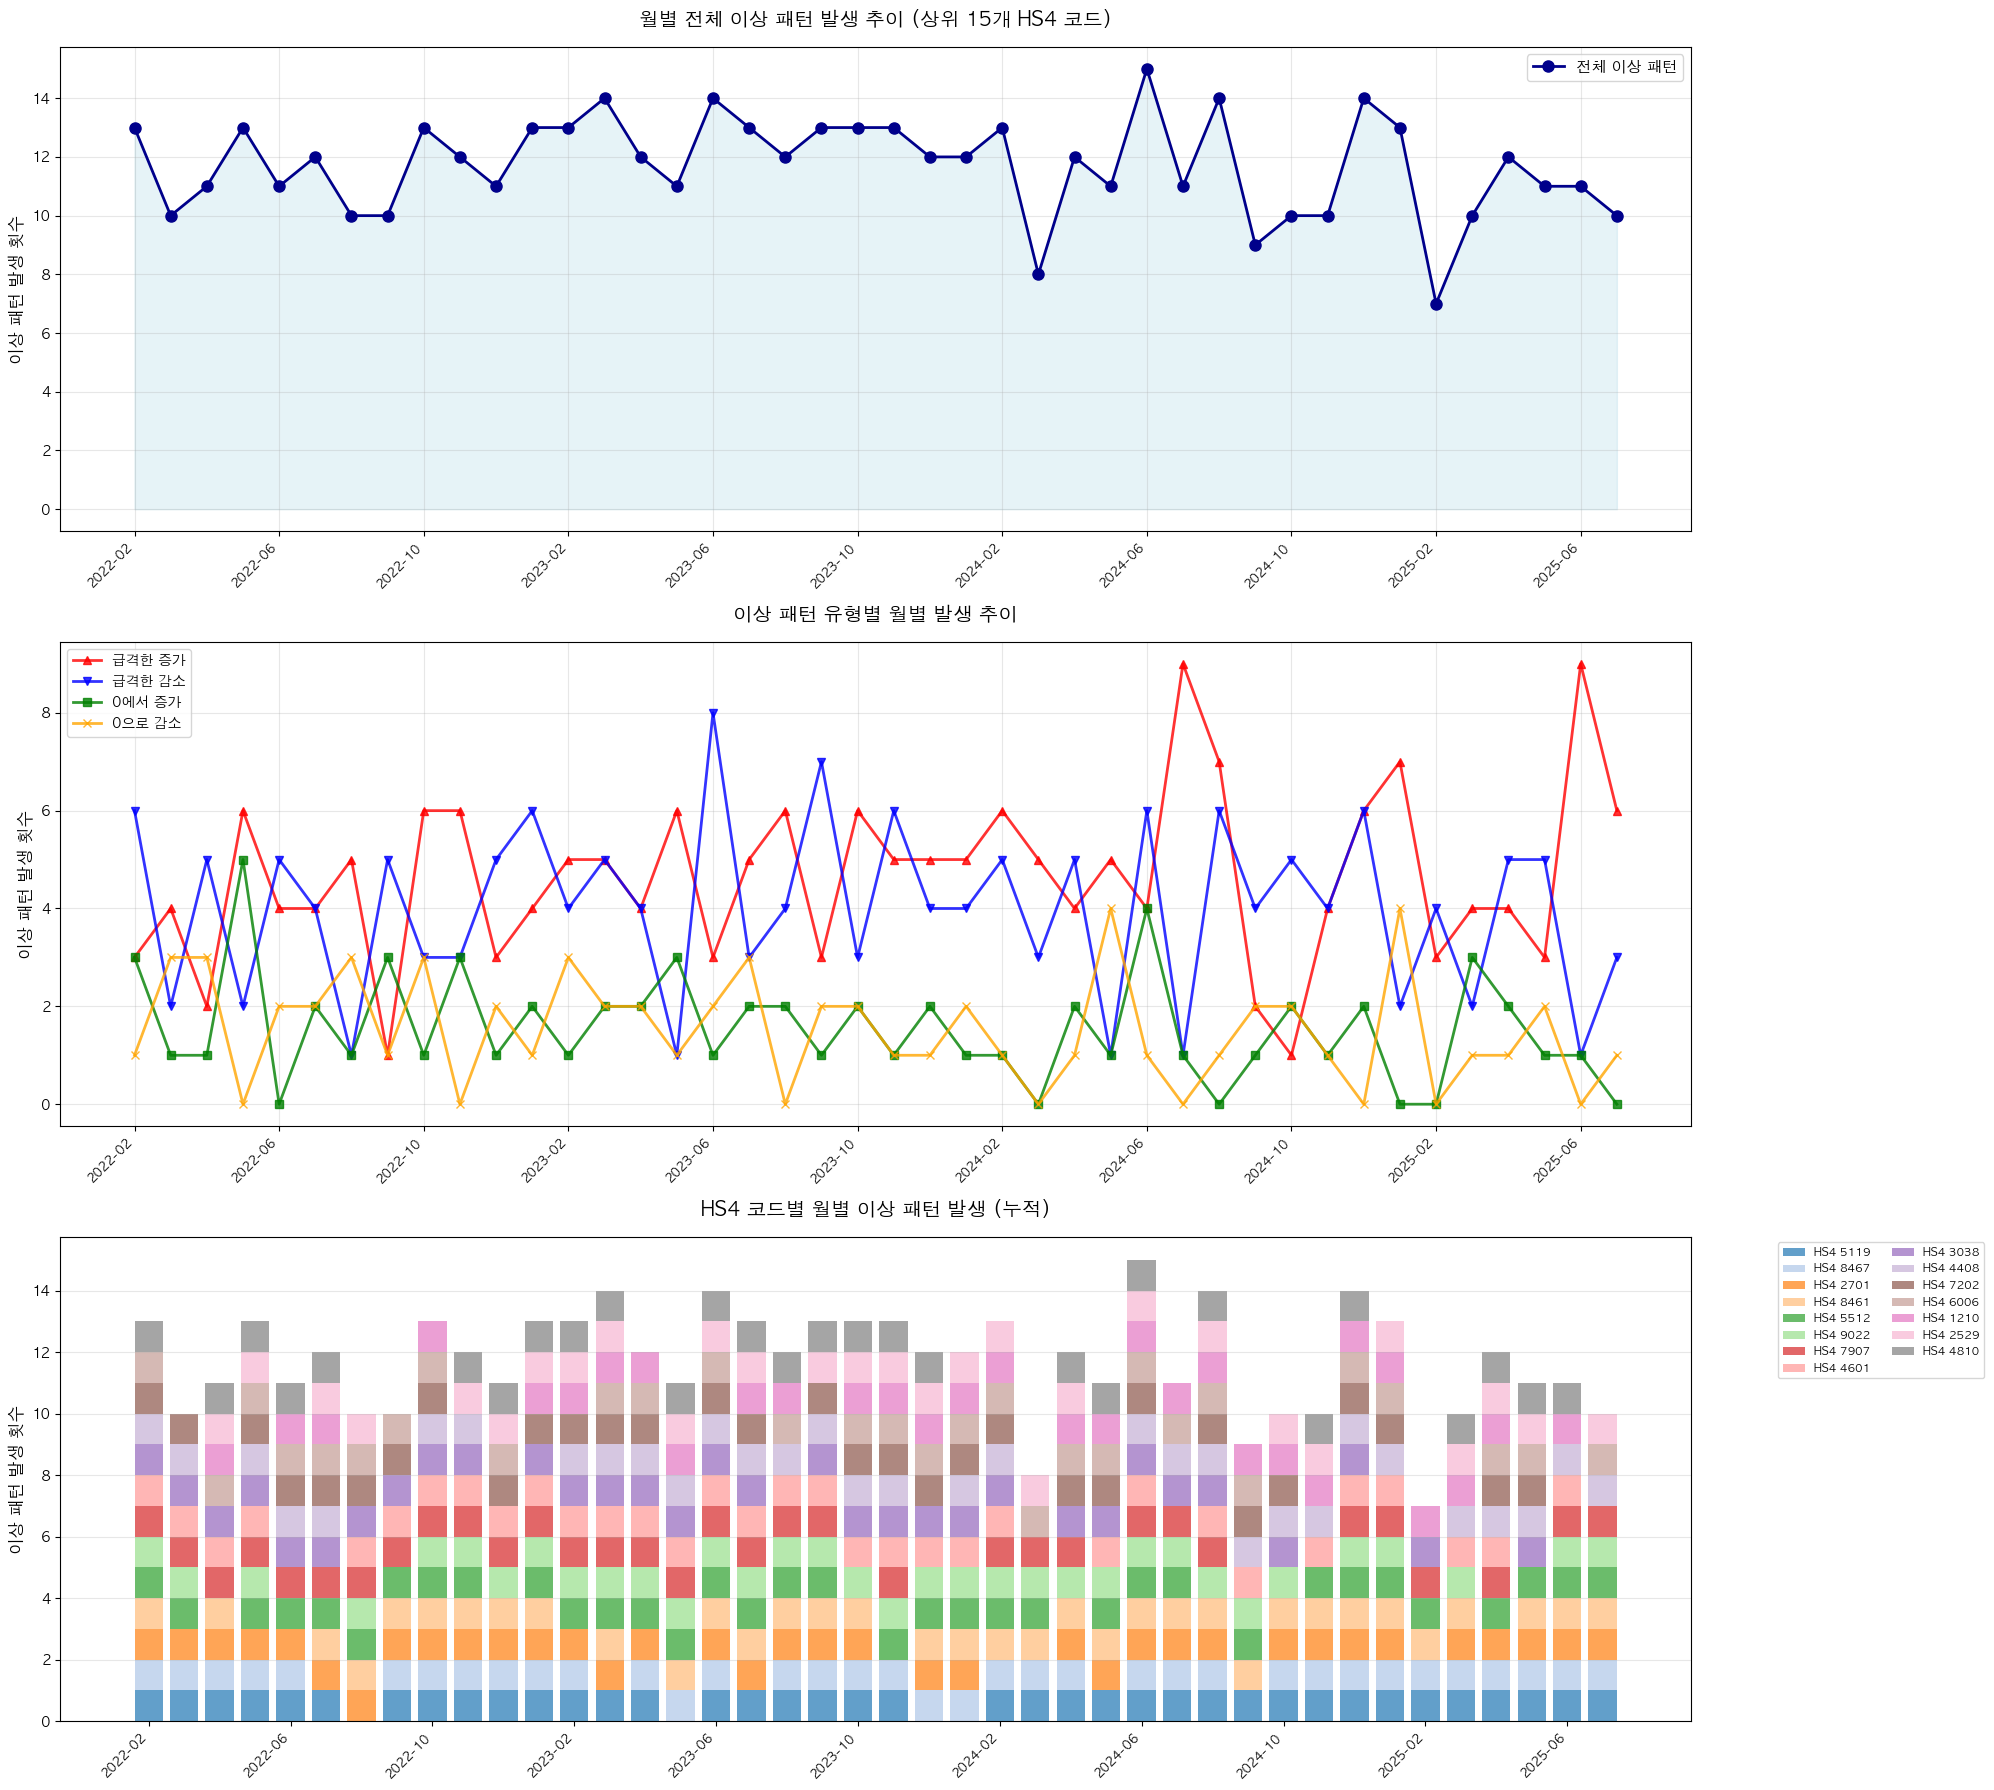

In [ ]:
# 월별 × HS4 코드별 이상 패턴 상세 타임라인 시각화
if len(anomalies_df) > 0:
    print("\n" + "="*70)
    print("월별 × HS4 코드별 이상 패턴 타임라인 시각화")
    print("="*70)
    
    # 상위 15개 HS4 코드 선택
    top15_hs4 = hs4_anomaly_count.head(15).index.tolist()
    top15_anomalies = anomalies_df[anomalies_df['hs4'].isin(top15_hs4)].copy()
    
    # 이상 패턴 유형별 색상 매핑
    color_map = {
        '급격한 증가': 'red',
        '급격한 감소': 'blue',
        '0에서 증가': 'green',
        '0으로 감소': 'orange'
    }
    
    marker_map = {
        '급격한 증가': '^',
        '급격한 감소': 'v',
        '0에서 증가': 's',
        '0으로 감소': 'x'
    }
    
    # 타임라인 시각화
    fig, axes = plt.subplots(3, 1, figsize=(20, 18))
    
    # 1. 월별 전체 이상 패턴 발생 추이
    monthly_total = top15_anomalies.groupby('month_str').size().sort_index()
    axes[0].plot(range(len(monthly_total)), monthly_total.values, 
                marker='o', linewidth=2, markersize=8, color='darkblue', label='전체 이상 패턴')
    axes[0].fill_between(range(len(monthly_total)), monthly_total.values, alpha=0.3, color='lightblue')
    axes[0].set_xticks(range(0, len(monthly_total), max(1, len(monthly_total)//10)))
    axes[0].set_xticklabels([monthly_total.index[i] for i in range(0, len(monthly_total), max(1, len(monthly_total)//10))], 
                            rotation=45, ha='right', fontsize=9)
    axes[0].set_ylabel('이상 패턴 발생 횟수', fontsize=12)
    axes[0].set_title('월별 전체 이상 패턴 발생 추이 (상위 15개 HS4 코드)', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=11)
    
    # 2. 이상 패턴 유형별 월별 발생 추이
    for change_type in ['급격한 증가', '급격한 감소', '0에서 증가', '0으로 감소']:
        type_monthly = top15_anomalies[top15_anomalies['change_type'] == change_type].groupby('month_str').size().sort_index()
        if len(type_monthly) > 0:
            # 월별 인덱스 맞추기
            type_monthly_aligned = pd.Series(0, index=monthly_total.index)
            for month in type_monthly.index:
                if month in type_monthly_aligned.index:
                    type_monthly_aligned[month] = type_monthly[month]
            
            axes[1].plot(range(len(type_monthly_aligned)), type_monthly_aligned.values,
                        marker=marker_map[change_type], linewidth=2, markersize=6,
                        color=color_map[change_type], label=change_type, alpha=0.8)
    
    axes[1].set_xticks(range(0, len(monthly_total), max(1, len(monthly_total)//10)))
    axes[1].set_xticklabels([monthly_total.index[i] for i in range(0, len(monthly_total), max(1, len(monthly_total)//10))], 
                            rotation=45, ha='right', fontsize=9)
    axes[1].set_ylabel('이상 패턴 발생 횟수', fontsize=12)
    axes[1].set_title('이상 패턴 유형별 월별 발생 추이', fontsize=14, fontweight='bold', pad=15)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper left', fontsize=10)
    
    # 3. HS4 코드별 월별 이상 패턴 발생 (스택 바 차트)
    hs4_monthly_pivot = top15_anomalies.groupby(['month_str', 'hs4']).size().unstack(fill_value=0)
    hs4_monthly_pivot = hs4_monthly_pivot.reindex(columns=top15_hs4, fill_value=0)
    hs4_monthly_pivot = hs4_monthly_pivot.sort_index()
    
    # 누적 막대 그래프
    bottom = None
    colors = plt.cm.tab20(range(len(top15_hs4)))
    for i, hs4 in enumerate(top15_hs4):
        if hs4 in hs4_monthly_pivot.columns:
            values = hs4_monthly_pivot[hs4].values
            axes[2].bar(range(len(values)), values, bottom=bottom, 
                       label=f'HS4 {int(hs4)}', color=colors[i], alpha=0.7, width=0.8)
            if bottom is None:
                bottom = values
            else:
                bottom += values
    
    axes[2].set_xticks(range(0, len(hs4_monthly_pivot), max(1, len(hs4_monthly_pivot)//10)))
    axes[2].set_xticklabels([hs4_monthly_pivot.index[i] for i in range(0, len(hs4_monthly_pivot), max(1, len(hs4_monthly_pivot)//10))], 
                           rotation=45, ha='right', fontsize=9)
    axes[2].set_ylabel('이상 패턴 발생 횟수', fontsize=12)
    axes[2].set_title('HS4 코드별 월별 이상 패턴 발생 (누적)', fontsize=14, fontweight='bold', pad=15)
    axes[2].grid(True, alpha=0.3, axis='y')
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
    
    plt.tight_layout()
    plt.savefig('./images/hs4_monthly_anomalies_timeline.png', dpi=300, bbox_inches='tight')
    print("저장 완료: ./images/hs4_monthly_anomalies_timeline.png")
    plt.show()



월별 × HS4 코드별 상세 정보 테이블



저장 완료: ./results/hs4_monthly_anomalies_detail_table.csv
총 614건의 월별 × HS4 코드별 상세 정보

월별 요약 (상위 5개 월):

2023-07:
  - 이상 패턴 발생 HS4 코드 수: 18개
  - 총 이상 패턴 발생 횟수: 18건
  - 주요 HS4 코드 및 패턴:
    • HS4 2612 (기타): 0에서 증가 1건
    • HS4 2701 (석탄): 0에서 증가 1건
    • HS4 9022 (X선 장치): 0에서 증가 1건

2022-08:
  - 이상 패턴 발생 HS4 코드 수: 17개
  - 총 이상 패턴 발생 횟수: 17건
  - 주요 HS4 코드 및 패턴:
    • HS4 2701 (석탄): 0에서 증가 1건
    • HS4 4302 (기타): 0에서 증가 1건
    • HS4 2612 (기타): 0으로 감소 1건

2025-01:
  - 이상 패턴 발생 HS4 코드 수: 17개
  - 총 이상 패턴 발생 횟수: 17건
  - 주요 HS4 코드 및 패턴:
    • HS4 4403 (목재): 0에서 증가 1건
    • HS4 8105 (코발트): 0에서 증가 1건
    • HS4 2612 (기타): 0으로 감소 1건

2023-02:
  - 이상 패턴 발생 HS4 코드 수: 17개
  - 총 이상 패턴 발생 횟수: 17건
  - 주요 HS4 코드 및 패턴:
    • HS4 3813 (기타 화학 제품): 0에서 증가 1건
    • HS4 4302 (기타): 0에서 증가 1건
    • HS4 4810 (펄프, 종이): 0에서 증가 1건

2023-03:
  - 이상 패턴 발생 HS4 코드 수: 17개
  - 총 이상 패턴 발생 횟수: 17건
  - 주요 HS4 코드 및 패턴:
    • HS4 3024 (의약품): 0에서 증가 1건
    • HS4 4408 (합판): 0에서 증가 1건
    • HS4 9022 (X선 장치): 0에서 증가 1건



시각화 저장 완료: ./images/hs4_monthly_anomalies_detail_table.png


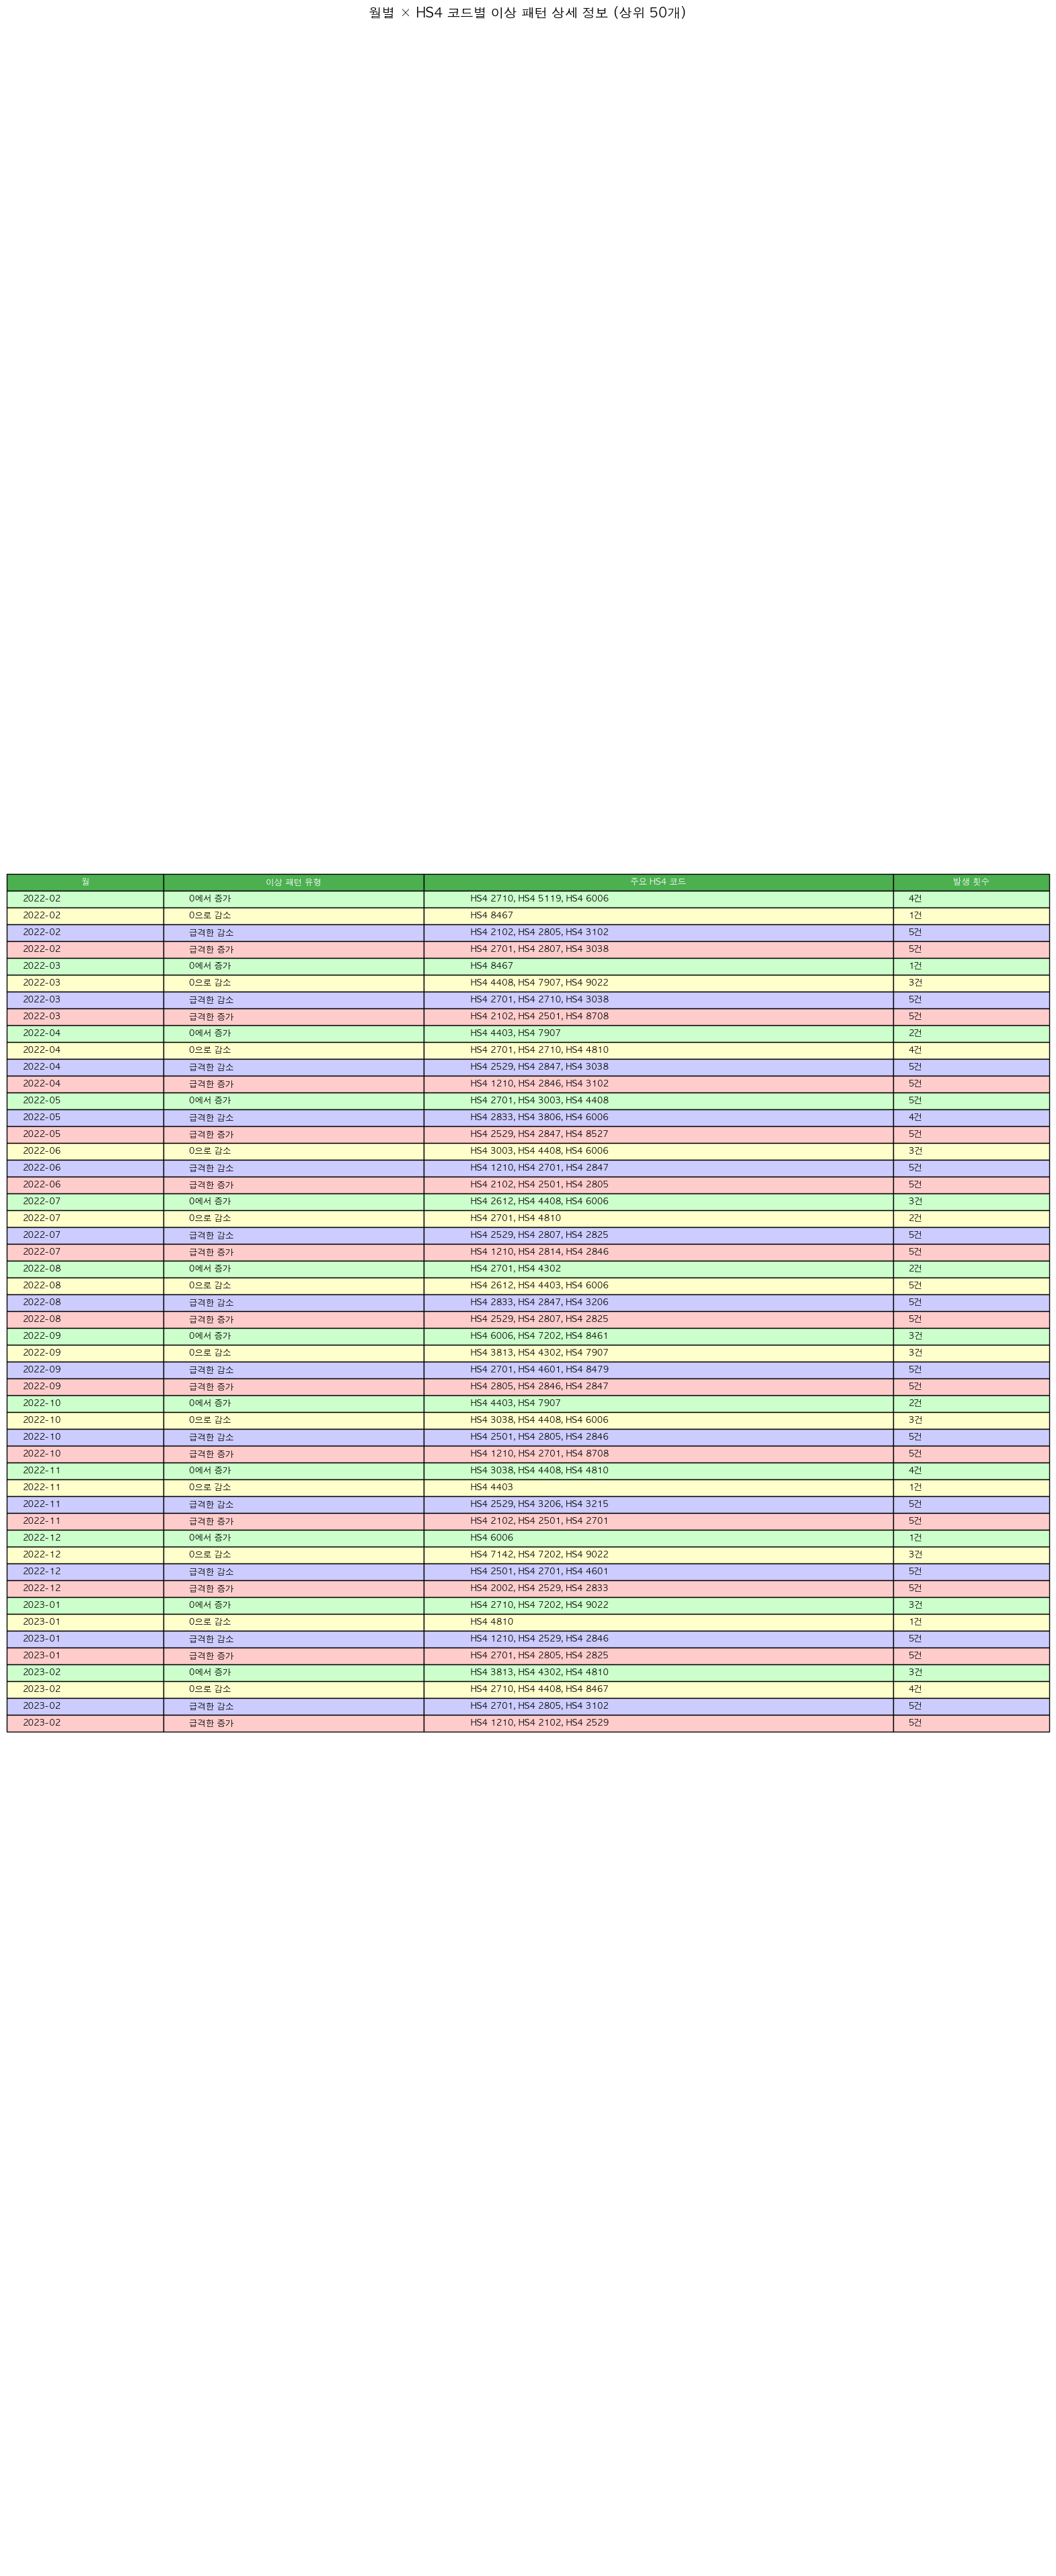

In [ ]:
# 월별 × HS4 코드별 상세 정보 테이블 생성
if len(anomalies_df) > 0:
    print("\n" + "="*70)
    print("월별 × HS4 코드별 상세 정보 테이블")
    print("="*70)
    
    # 월별로 그룹화하여 상세 정보 생성
    monthly_hs4_detail = []
    
    for month in sorted(anomalies_df['month_str'].unique()):
        month_anomalies = anomalies_df[anomalies_df['month_str'] == month]
        
        for change_type in ['급격한 증가', '급격한 감소', '0에서 증가', '0으로 감소']:
            type_anomalies = month_anomalies[month_anomalies['change_type'] == change_type]
            
            if len(type_anomalies) > 0:
                # 상위 5개 HS4 코드
                top_hs4_in_month = type_anomalies.groupby('hs4').size().sort_values(ascending=False).head(5)
                
                for hs4, count in top_hs4_in_month.items():
                    hs4_info = type_anomalies[type_anomalies['hs4'] == hs4].iloc[0]
                    hs4_desc = hs4_descriptions.get(int(hs4), get_hs4_category(hs4))
                    
                    monthly_hs4_detail.append({
                        'month': month,
                        'change_type': change_type,
                        'hs4': int(hs4),
                        'description': hs4_desc,
                        'category': get_hs4_category(hs4),
                        'occurrence_count': count,
                        'avg_change_amount': type_anomalies[type_anomalies['hs4'] == hs4]['change_amount'].mean(),
                        'max_change_amount': type_anomalies[type_anomalies['hs4'] == hs4]['change_amount'].max()
                    })
    
    monthly_detail_df = pd.DataFrame(monthly_hs4_detail)
    
    if len(monthly_detail_df) > 0:
        # 월별로 정렬
        monthly_detail_df = monthly_detail_df.sort_values(['month', 'change_type', 'occurrence_count'], 
                                                          ascending=[True, True, False])
        
        # 결과 저장
        monthly_detail_df.to_csv('./results/hs4_monthly_anomalies_detail_table.csv', 
                                index=False, encoding='utf-8-sig')
        print(f"\n저장 완료: ./results/hs4_monthly_anomalies_detail_table.csv")
        print(f"총 {len(monthly_detail_df)}건의 월별 × HS4 코드별 상세 정보")
        
        # 월별 요약 출력
        print("\n월별 요약 (상위 5개 월):")
        monthly_summary = monthly_detail_df.groupby('month').agg({
            'hs4': 'nunique',
            'occurrence_count': 'sum'
        }).sort_values('occurrence_count', ascending=False).head(5)
        
        for month, row in monthly_summary.iterrows():
            print(f"\n{month}:")
            print(f"  - 이상 패턴 발생 HS4 코드 수: {row['hs4']}개")
            print(f"  - 총 이상 패턴 발생 횟수: {int(row['occurrence_count'])}건")
            
            month_data = monthly_detail_df[monthly_detail_df['month'] == month]
            print(f"  - 주요 HS4 코드 및 패턴:")
            for _, detail_row in month_data.head(3).iterrows():
                print(f"    • HS4 {detail_row['hs4']} ({detail_row['description']}): "
                     f"{detail_row['change_type']} {int(detail_row['occurrence_count'])}건")
    
    # 월별 × HS4 코드별 상세 정보 시각화 (테이블 형태)
    if len(monthly_detail_df) > 0:
        # 월별로 그룹화하여 주요 정보 추출
        monthly_summary_viz = monthly_detail_df.groupby(['month', 'change_type']).agg({
            'hs4': lambda x: ', '.join([f'HS4 {int(h)}' for h in x.head(3)]),
            'occurrence_count': 'sum'
        }).reset_index()
        
        # 월별 주요 이상 패턴 시각화
        fig, ax = plt.subplots(figsize=(20, max(8, len(monthly_summary_viz) * 0.3)))
        ax.axis('tight')
        ax.axis('off')
        
        # 테이블 데이터 준비
        table_data = []
        for month in sorted(monthly_summary_viz['month'].unique()):
            month_data = monthly_summary_viz[monthly_summary_viz['month'] == month]
            for _, row in month_data.iterrows():
                table_data.append([
                    row['month'],
                    row['change_type'],
                    row['hs4'],
                    f"{int(row['occurrence_count'])}건"
                ])
        
        if len(table_data) > 0:
            table = ax.table(cellText=table_data[:50],  # 상위 50개만 표시
                           colLabels=['월', '이상 패턴 유형', '주요 HS4 코드', '발생 횟수'],
                           cellLoc='left',
                           loc='center',
                           colWidths=[0.15, 0.25, 0.45, 0.15])
            
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
            
            # 헤더 스타일
            for i in range(4):
                table[(0, i)].set_facecolor('#4CAF50')
                table[(0, i)].set_text_props(weight='bold', color='white')
            
            # 행별 색상 (이상 패턴 유형별)
            color_map_table = {
                '급격한 증가': '#ffcccc',
                '급격한 감소': '#ccccff',
                '0에서 증가': '#ccffcc',
                '0으로 감소': '#ffffcc'
            }
            
            for i in range(1, min(len(table_data) + 1, 51)):
                change_type = table_data[i-1][1]
                color = color_map_table.get(change_type, '#ffffff')
                for j in range(4):
                    table[(i, j)].set_facecolor(color)
            
            ax.set_title('월별 × HS4 코드별 이상 패턴 상세 정보 (상위 50개)', 
                        fontsize=14, fontweight='bold', pad=20)
            
            plt.savefig('./images/hs4_monthly_anomalies_detail_table.png', dpi=300, bbox_inches='tight')
            print("\n시각화 저장 완료: ./images/hs4_monthly_anomalies_detail_table.png")
            plt.show()


## 4-4. item_id와 HS4 코드 매칭 관계 분석


In [ ]:
print("\n" + "="*70)
print("[4-4단계] item_id와 HS4 코드 매칭 관계 분석")
print("="*70)

# item_id와 HS4 코드 매칭 관계 분석
item_hs4_mapping = train[['item_id', 'hs4']].drop_duplicates().copy()

print(f"\n기본 통계:")
print(f"  - 총 item_id 수: {item_hs4_mapping['item_id'].nunique()}개")
print(f"  - 총 HS4 코드 수: {item_hs4_mapping['hs4'].nunique()}개")
print(f"  - 총 매칭 관계 수: {len(item_hs4_mapping)}개")

# item_id별 HS4 코드 수
item_hs4_count = item_hs4_mapping.groupby('item_id')['hs4'].nunique()
print(f"\nitem_id별 HS4 코드 수 분포:")
print(f"  - 1개 HS4 코드를 가진 item_id: {(item_hs4_count == 1).sum()}개")
print(f"  - 2개 이상 HS4 코드를 가진 item_id: {(item_hs4_count > 1).sum()}개")

if (item_hs4_count > 1).sum() > 0:
    print(f"\n여러 HS4 코드를 가진 item_id (상위 10개):")
    multi_hs4_items = item_hs4_count[item_hs4_count > 1].sort_values(ascending=False)
    print(multi_hs4_items.head(10))

# HS4 코드별 item_id 수
hs4_item_count = item_hs4_mapping.groupby('hs4')['item_id'].nunique().sort_values(ascending=False)
print(f"\nHS4 코드별 item_id 수 (상위 20개):")
print(hs4_item_count.head(20))

# 매칭 관계 상세 정보
mapping_detail = []
for item_id in item_hs4_mapping['item_id'].unique():
    item_hs4s = item_hs4_mapping[item_hs4_mapping['item_id'] == item_id]['hs4'].tolist()
    item_data = train[train['item_id'] == item_id]
    total_value = item_data['value'].sum()
    total_weight = item_data['weight'].sum()
    transaction_count = len(item_data)
    
    mapping_detail.append({
        'item_id': item_id,
        'hs4_codes': item_hs4s,
        'hs4_count': len(item_hs4s),
        'hs4_codes_str': ', '.join([str(hs4) for hs4 in item_hs4s]),
        'total_value': total_value,
        'total_weight': total_weight,
        'transaction_count': transaction_count
    })

mapping_detail_df = pd.DataFrame(mapping_detail)
mapping_detail_df = mapping_detail_df.sort_values('hs4_count', ascending=False)

print(f"\n매칭 관계 상세 정보 저장 중...")
mapping_detail_df.to_csv('./results/item_hs4_mapping.csv', index=False, encoding='utf-8-sig')
print(f"저장 완료: ./results/item_hs4_mapping.csv")



[4-4단계] item_id와 HS4 코드 매칭 관계 분석

기본 통계:
  - 총 item_id 수: 100개
  - 총 HS4 코드 수: 71개
  - 총 매칭 관계 수: 100개

item_id별 HS4 코드 수 분포:
  - 1개 HS4 코드를 가진 item_id: 100개
  - 2개 이상 HS4 코드를 가진 item_id: 0개

HS4 코드별 item_id 수 (상위 20개):
hs4
2805    6
3824    5
8501    5
2811    4
8102    3
3815    3
8505    3
2807    3
7207    2
2846    2
3102    2
2529    2
8714    2
5205    1
6006    1
5402    1
5119    1
5111    1
5512    1
5515    1
Name: item_id, dtype: int64

매칭 관계 상세 정보 저장 중...
저장 완료: ./results/item_hs4_mapping.csv



item_id와 HS4 코드 매칭 관계 시각화



시각화 저장 완료: ./images/item_hs4_mapping_analysis.png


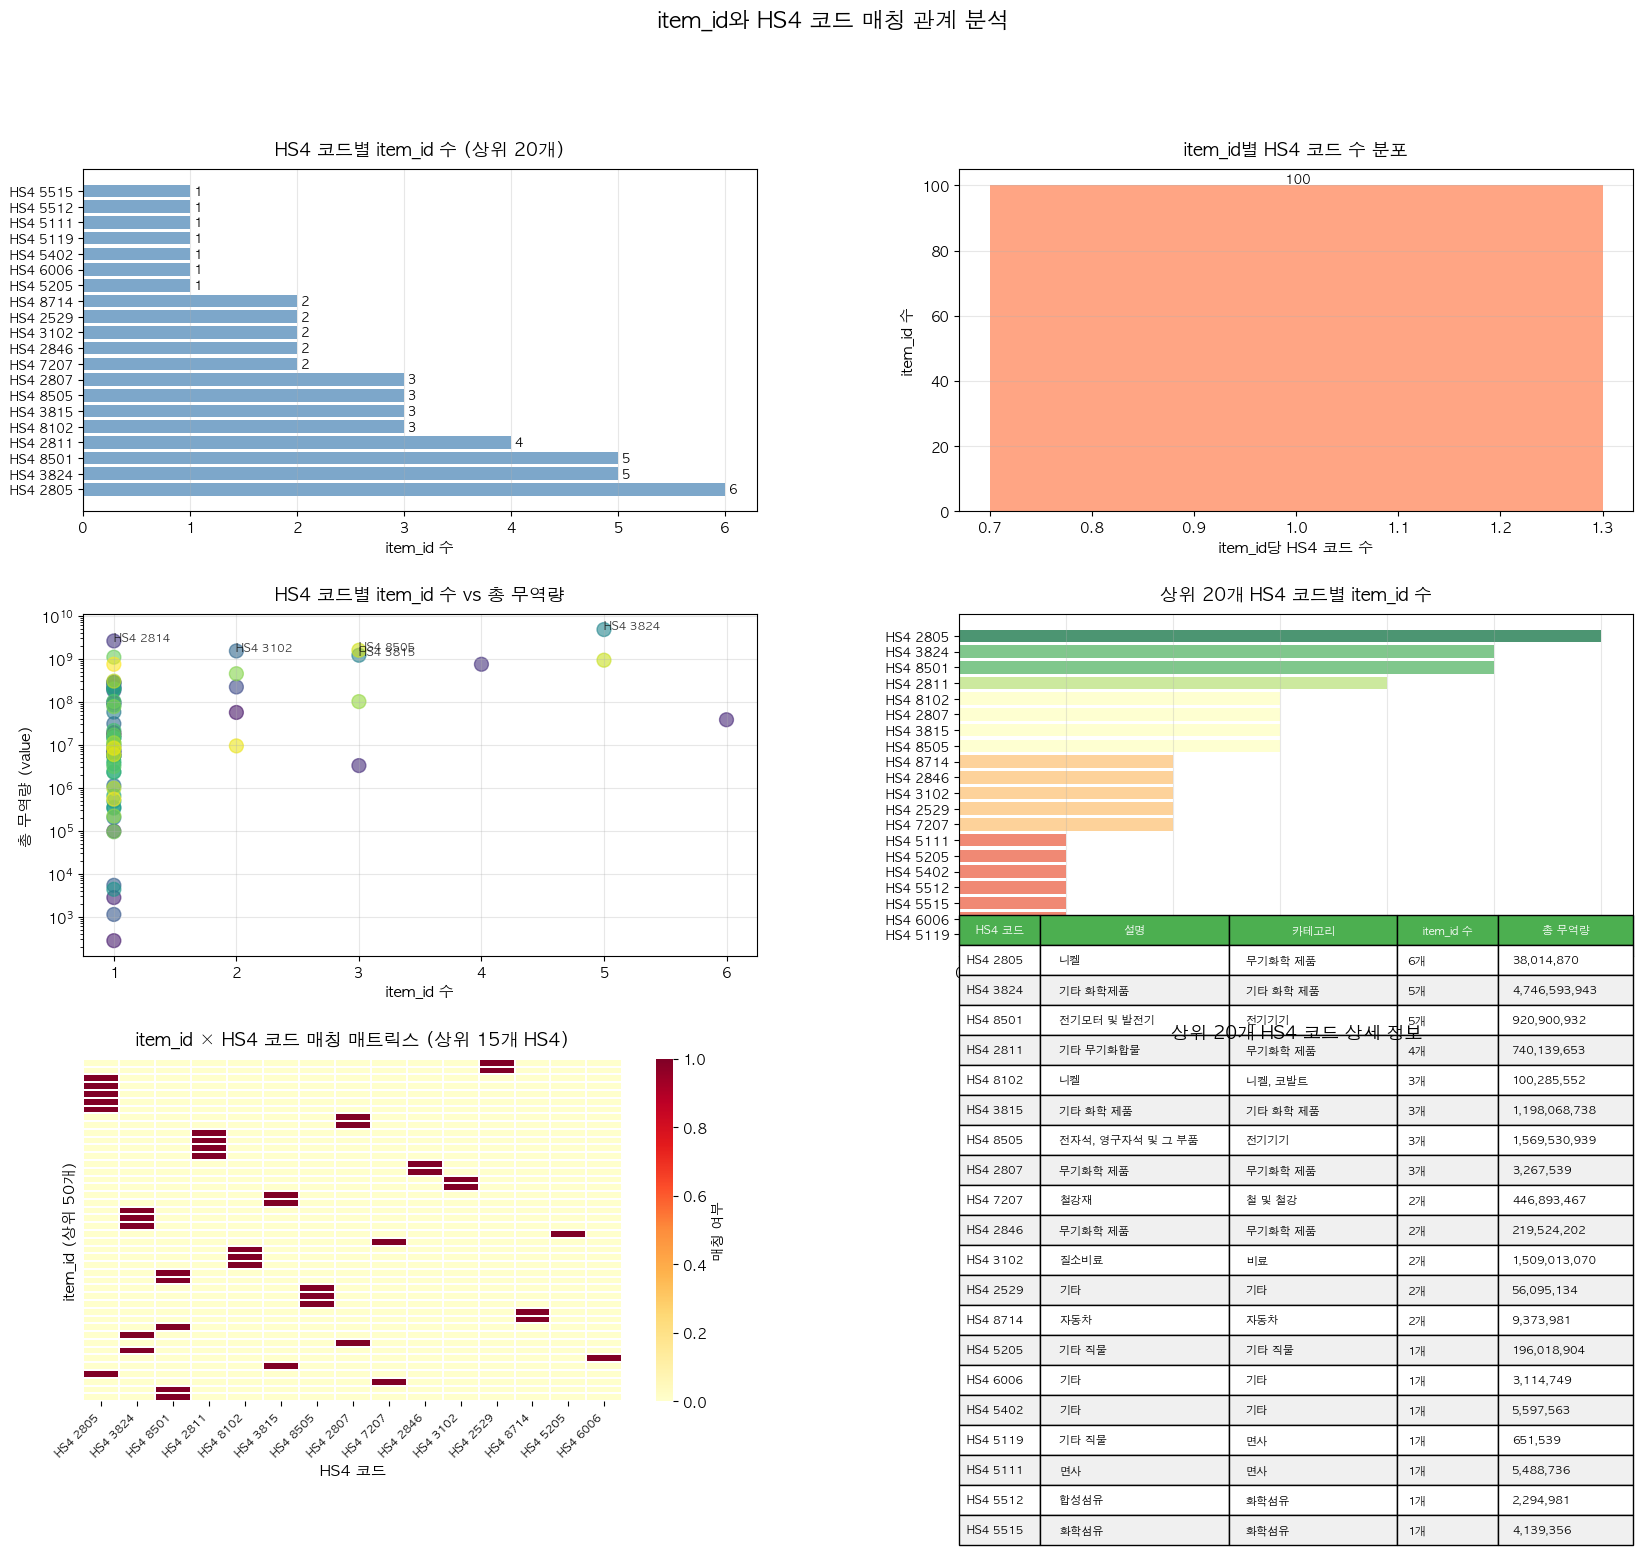

In [ ]:
# item_id와 HS4 코드 매칭 관계 시각화
print("\n" + "="*70)
print("item_id와 HS4 코드 매칭 관계 시각화")
print("="*70)

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. HS4 코드별 item_id 수 분포 (막대 그래프)
ax1 = fig.add_subplot(gs[0, 0])
top20_hs4 = hs4_item_count.head(20)
bars = ax1.barh(range(len(top20_hs4)), top20_hs4.values, color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(top20_hs4)))
ax1.set_yticklabels([f'HS4 {int(hs4)}' for hs4 in top20_hs4.index], fontsize=9)
ax1.set_xlabel('item_id 수', fontsize=11)
ax1.set_title('HS4 코드별 item_id 수 (상위 20개)', fontsize=13, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3, axis='x')

# 값 표시
for i, (idx, val) in enumerate(top20_hs4.items()):
    ax1.text(val, i, f' {int(val)}', va='center', fontsize=9)

# 2. item_id별 HS4 코드 수 분포 (히스토그램)
ax2 = fig.add_subplot(gs[0, 1])
hs4_count_dist = item_hs4_count.value_counts().sort_index()
ax2.bar(hs4_count_dist.index, hs4_count_dist.values, color='coral', alpha=0.7, width=0.6)
ax2.set_xlabel('item_id당 HS4 코드 수', fontsize=11)
ax2.set_ylabel('item_id 수', fontsize=11)
ax2.set_title('item_id별 HS4 코드 수 분포', fontsize=13, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, axis='y')

# 값 표시
for x, y in zip(hs4_count_dist.index, hs4_count_dist.values):
    ax2.text(x, y, f' {int(y)}', va='bottom', ha='center', fontsize=9)

# 3. HS4 코드별 총 무역량 vs item_id 수 (산점도)
ax3 = fig.add_subplot(gs[1, 0])
hs4_stats = train.groupby('hs4').agg({
    'item_id': 'nunique',
    'value': 'sum'
}).reset_index()
hs4_stats.columns = ['hs4', 'item_count', 'total_value']

scatter = ax3.scatter(hs4_stats['item_count'], hs4_stats['total_value'], 
                     s=100, alpha=0.6, c=range(len(hs4_stats)), cmap='viridis')
ax3.set_xlabel('item_id 수', fontsize=11)
ax3.set_ylabel('총 무역량 (value)', fontsize=11)
ax3.set_title('HS4 코드별 item_id 수 vs 총 무역량', fontsize=13, fontweight='bold', pad=10)
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 상위 5개 HS4 코드 라벨 추가
top5_value = hs4_stats.nlargest(5, 'total_value')
for _, row in top5_value.iterrows():
    ax3.annotate(f'HS4 {int(row["hs4"])}', 
                (row['item_count'], row['total_value']),
                fontsize=8, alpha=0.8)

# 4. item_id와 HS4 코드 매칭 네트워크 (상위 20개 HS4 코드)
ax4 = fig.add_subplot(gs[1, 1])
top20_hs4_list = hs4_item_count.head(20).index.tolist()
top20_mapping = item_hs4_mapping[item_hs4_mapping['hs4'].isin(top20_hs4_list)]

# HS4 코드별 item_id 수를 막대 그래프로
hs4_item_counts_top20 = top20_mapping.groupby('hs4')['item_id'].nunique().sort_values(ascending=True)
ax4.barh(range(len(hs4_item_counts_top20)), hs4_item_counts_top20.values, 
        color=plt.cm.RdYlGn(hs4_item_counts_top20.values / hs4_item_counts_top20.max()), alpha=0.7)
ax4.set_yticks(range(len(hs4_item_counts_top20)))
ax4.set_yticklabels([f'HS4 {int(hs4)}' for hs4 in hs4_item_counts_top20.index], fontsize=9)
ax4.set_xlabel('item_id 수', fontsize=11)
ax4.set_title('상위 20개 HS4 코드별 item_id 수', fontsize=13, fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3, axis='x')

# 5. 매칭 관계 매트릭스 히트맵 (상위 15개 HS4 코드)
ax5 = fig.add_subplot(gs[2, 0])
top15_hs4_list = hs4_item_count.head(15).index.tolist()
top15_mapping = item_hs4_mapping[item_hs4_mapping['hs4'].isin(top15_hs4_list)]

# item_id별로 어떤 HS4 코드를 가지고 있는지 매트릭스 생성
item_list = top15_mapping['item_id'].unique()
matrix_data = []
for item_id in item_list:
    item_hs4s = set(top15_mapping[top15_mapping['item_id'] == item_id]['hs4'].tolist())
    row = [1 if hs4 in item_hs4s else 0 for hs4 in top15_hs4_list]
    matrix_data.append(row)

matrix_df = pd.DataFrame(matrix_data, 
                        index=item_list, 
                        columns=[f'HS4 {int(hs4)}' for hs4 in top15_hs4_list])

# 히트맵 생성 (매트릭스가 너무 크면 샘플링)
if len(matrix_df) > 50:
    # item_id를 총 무역량 기준으로 정렬하여 상위 50개만 선택
    item_values = train.groupby('item_id')['value'].sum().sort_values(ascending=False)
    top_items = item_values.head(50).index.tolist()
    matrix_df_sample = matrix_df.loc[matrix_df.index.intersection(top_items)]
else:
    matrix_df_sample = matrix_df

sns.heatmap(matrix_df_sample, cmap='YlOrRd', cbar_kws={'label': '매칭 여부'}, 
           linewidths=0.1, ax=ax5, xticklabels=True, yticklabels=False)
ax5.set_xlabel('HS4 코드', fontsize=11)
ax5.set_ylabel('item_id (상위 50개)', fontsize=11)
ax5.set_title('item_id × HS4 코드 매칭 매트릭스 (상위 15개 HS4)', 
             fontsize=13, fontweight='bold', pad=10)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# 6. 상위 20개 HS4 코드의 상세 정보 테이블
ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('tight')
ax6.axis('off')

# 테이블 데이터 준비
table_data = []
for hs4 in top20_hs4_list:
    hs4_items = item_hs4_mapping[item_hs4_mapping['hs4'] == hs4]['item_id'].tolist()
    hs4_desc = hs4_descriptions.get(int(hs4), get_hs4_category(hs4))
    hs4_category = get_hs4_category(hs4)
    hs4_value = train[train['hs4'] == hs4]['value'].sum()
    
    table_data.append([
        f'HS4 {int(hs4)}',
        hs4_desc[:25] + '...' if len(hs4_desc) > 25 else hs4_desc,
        hs4_category[:20] + '...' if len(hs4_category) > 20 else hs4_category,
        f'{len(hs4_items)}개',
        f'{hs4_value:,.0f}'
    ])

table = ax6.table(cellText=table_data,
                 colLabels=['HS4 코드', '설명', '카테고리', 'item_id 수', '총 무역량'],
                 cellLoc='left',
                 loc='center',
                 colWidths=[0.12, 0.28, 0.25, 0.15, 0.20])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.8)

# 헤더 스타일
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# 행별 색상
for i in range(1, len(table_data) + 1):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax6.set_title('상위 20개 HS4 코드 상세 정보', fontsize=13, fontweight='bold', pad=15)

plt.suptitle('item_id와 HS4 코드 매칭 관계 분석', fontsize=16, fontweight='bold', y=0.98)
plt.savefig('./images/item_hs4_mapping_analysis.png', dpi=300, bbox_inches='tight')
print("\n시각화 저장 완료: ./images/item_hs4_mapping_analysis.png")
plt.show()


In [ ]:
# item_id별 상세 매칭 정보 시각화
print("\n" + "="*70)
print("item_id별 HS4 코드 매칭 상세 정보")
print("="*70)

# 여러 HS4 코드를 가진 item_id 분석
multi_hs4_items = mapping_detail_df[mapping_detail_df['hs4_count'] > 1].copy()

if len(multi_hs4_items) > 0:
    print(f"\n여러 HS4 코드를 가진 item_id: {len(multi_hs4_items)}개")
    print("\n상위 10개 item_id의 HS4 코드 매칭:")
    for idx, row in multi_hs4_items.head(10).iterrows():
        print(f"\nitem_id {row['item_id']}:")
        print(f"  - HS4 코드: {row['hs4_codes_str']} ({row['hs4_count']}개)")
        print(f"  - 총 무역량: {row['total_value']:,.0f}")
        print(f"  - 거래 건수: {row['transaction_count']:,}건")
    
    # 여러 HS4 코드를 가진 item_id 시각화
    fig, axes = plt.subplots(2, 1, figsize=(18, 12))
    
    # 1. 여러 HS4 코드를 가진 item_id의 HS4 코드 수 분포
    ax1 = axes[0]
    hs4_count_dist_multi = multi_hs4_items['hs4_count'].value_counts().sort_index()
    bars = ax1.bar(hs4_count_dist_multi.index, hs4_count_dist_multi.values, 
                  color='coral', alpha=0.7, width=0.6)
    ax1.set_xlabel('item_id당 HS4 코드 수', fontsize=12)
    ax1.set_ylabel('item_id 수', fontsize=12)
    ax1.set_title('여러 HS4 코드를 가진 item_id의 HS4 코드 수 분포', 
                 fontsize=14, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for x, y in zip(hs4_count_dist_multi.index, hs4_count_dist_multi.values):
        ax1.text(x, y, f' {int(y)}', va='bottom', ha='center', fontsize=10)
    
    # 2. 여러 HS4 코드를 가진 item_id의 총 무역량 vs HS4 코드 수
    ax2 = axes[1]
    scatter = ax2.scatter(multi_hs4_items['hs4_count'], multi_hs4_items['total_value'],
                         s=multi_hs4_items['transaction_count']/10, alpha=0.6, 
                         c=range(len(multi_hs4_items)), cmap='viridis')
    ax2.set_xlabel('HS4 코드 수', fontsize=12)
    ax2.set_ylabel('총 무역량 (value)', fontsize=12)
    ax2.set_title('여러 HS4 코드를 가진 item_id: HS4 코드 수 vs 총 무역량\n(버블 크기 = 거래 건수)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    # 상위 5개 item_id 라벨 추가
    top5_multi = multi_hs4_items.nlargest(5, 'total_value')
    for _, row in top5_multi.iterrows():
        ax2.annotate(f'item_{int(row["item_id"])}', 
                    (row['hs4_count'], row['total_value']),
                    fontsize=8, alpha=0.8)
    
    plt.tight_layout()
    plt.savefig('./images/item_multi_hs4_analysis.png', dpi=300, bbox_inches='tight')
    print("\n시각화 저장 완료: ./images/item_multi_hs4_analysis.png")
    plt.show()
else:
    print("\n여러 HS4 코드를 가진 item_id가 없습니다.")

# item_id별 HS4 코드 매칭 요약 통계
print("\n" + "="*70)
print("매칭 관계 요약 통계")
print("="*70)
print(f"\n1:1 매칭 (1개 item_id = 1개 HS4 코드): {(item_hs4_count == 1).sum()}개")
print(f"1:N 매칭 (1개 item_id = 여러 HS4 코드): {(item_hs4_count > 1).sum()}개")
print(f"\n평균 item_id당 HS4 코드 수: {item_hs4_count.mean():.2f}개")
print(f"최대 item_id당 HS4 코드 수: {item_hs4_count.max()}개")

# HS4 코드별 통계
print(f"\nHS4 코드별 평균 item_id 수: {hs4_item_count.mean():.2f}개")
print(f"HS4 코드별 최대 item_id 수: {hs4_item_count.max()}개")
print(f"HS4 코드별 최소 item_id 수: {hs4_item_count.min()}개")



item_id별 HS4 코드 매칭 상세 정보

여러 HS4 코드를 가진 item_id가 없습니다.

매칭 관계 요약 통계

1:1 매칭 (1개 item_id = 1개 HS4 코드): 100개
1:N 매칭 (1개 item_id = 여러 HS4 코드): 0개

평균 item_id당 HS4 코드 수: 1.00개
최대 item_id당 HS4 코드 수: 1개

HS4 코드별 평균 item_id 수: 1.41개
HS4 코드별 최대 item_id 수: 6개
HS4 코드별 최소 item_id 수: 1개


## 5. Baseline 모델 학습


In [ ]:
print("\n" + "="*70)
print("[5단계] Baseline 모델 학습")
print("="*70)

def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), desc="Finding comovement pairs", total=len(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# 공행성쌍 탐색
print("\n공행성쌍 탐색 중...")
pairs_baseline = find_comovement_pairs(pivot)
print(f"탐색된 공행성쌍 수: {len(pairs_baseline)}")



[5단계] Baseline 모델 학습

공행성쌍 탐색 중...



Finding comovement pairs:   0%|          | 0/100 [00:00<?, ?it/s]


Finding comovement pairs:   8%|▊         | 8/100 [00:00<00:01, 77.05it/s]


Finding comovement pairs:  16%|█▌        | 16/100 [00:00<00:01, 71.30it/s]


Finding comovement pairs:  24%|██▍       | 24/100 [00:00<00:01, 69.93it/s]


Finding comovement pairs:  33%|███▎      | 33/100 [00:00<00:00, 76.55it/s]


Finding comovement pairs:  41%|████      | 41/100 [00:00<00:00, 73.58it/s]


Finding comovement pairs:  49%|████▉     | 49/100 [00:00<00:00, 75.10it/s]


Finding comovement pairs:  57%|█████▋    | 57/100 [00:00<00:00, 72.76it/s]


Finding comovement pairs:  66%|██████▌   | 66/100 [00:00<00:00, 76.47it/s]


Finding comovement pairs:  75%|███████▌  | 75/100 [00:00<00:00, 78.18it/s]


Finding comovement pairs:  83%|████████▎ | 83/100 [00:01<00:00, 76.03it/s]


Finding comovement pairs:  91%|█████████ | 91/100 [00:01<00:00, 72.41it/s]


Finding comovement pairs:  99%|█████████▉| 99/100 [00:01<00:00, 68.69it/s]


Finding comovement pairs: 100%|██████████| 100/100 [00:01<00:00, 72.71it/s]

탐색된 공행성쌍 수: 1425


In [ ]:
def build_training_data(pivot, pairs):
    months = pivot.columns.to_list()
    n_months = len(months)
    rows = []

    for row in tqdm(pairs.itertuples(index=False), desc="Building training data", total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

# 학습 데이터 생성
print("\n학습 데이터 생성 중...")
df_train_baseline = build_training_data(pivot, pairs_baseline)
print(f'생성된 학습 데이터 shape: {df_train_baseline.shape}')

# 모델 학습
print("\n모델 학습 중...")
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']
train_X = df_train_baseline[feature_cols].values
train_y = df_train_baseline["target"].values

reg_baseline = LinearRegression()
reg_baseline.fit(train_X, train_y)
print("Baseline 모델 학습 완료!")



학습 데이터 생성 중...



Building training data:   0%|          | 0/1425 [00:00<?, ?it/s]


Building training data: 100%|██████████| 1425/1425 [00:00<00:00, 39015.38it/s]

생성된 학습 데이터 shape: (54743, 6)

모델 학습 중...
Baseline 모델 학습 완료!


In [ ]:
def predict(pivot, pairs, reg):
    months = pivot.columns.to_list()
    n_months = len(months)
    t_last = n_months - 1
    t_prev = n_months - 2
    preds = []

    for row in tqdm(pairs.itertuples(index=False), desc="Making predictions", total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        if t_last - lag < 0:
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        y_pred = reg.predict(X_test)[0]
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

# Baseline 모델 예측
print("\nBaseline 모델 예측 중...")
submission_baseline = predict(pivot, pairs_baseline, reg_baseline)
submission_baseline.to_csv('./results/baseline_submit.csv', index=False)
print(f"Baseline 예측 완료: {len(submission_baseline)}개 쌍")
print(f"저장 완료: ./results/baseline_submit.csv")



Baseline 모델 예측 중...



Making predictions:   0%|          | 0/1425 [00:00<?, ?it/s]


Making predictions: 100%|██████████| 1425/1425 [00:00<00:00, 33033.50it/s]

Baseline 예측 완료: 1425개 쌍
저장 완료: ./results/baseline_submit.csv


## 6. 공급망 기반 모델 학습


In [ ]:
print("\n" + "="*70)
print("[6단계] 공급망 기반 모델 학습")
print("="*70)

def get_supply_chain_tier_num(hs4):
    """HS4 코드를 기반으로 공급망 계층 번호 반환"""
    if 8400 <= hs4 < 8600 or 8600 <= hs4 < 9000 or 9000 <= hs4 < 9300:
        return 3  # 최종제품
    elif 7200 <= hs4 < 8400:
        return 2  # 중간재
    elif 2800 <= hs4 < 3900:
        return 1  # 원자재
    else:
        return 0  # 기타

def get_supply_chain_direction(leader_hs4, follower_hs4):
    """공급망 방향성 점수 계산"""
    leader_tier = get_supply_chain_tier_num(leader_hs4)
    follower_tier = get_supply_chain_tier_num(follower_hs4)
    
    if leader_hs4 == follower_hs4:
        return 1.5
    if leader_tier < follower_tier:
        return 2.0
    elif leader_tier == follower_tier:
        return 1.0
    else:
        return 0.5

def find_comovement_pairs_supply_chain(pivot, item_hs4, max_lag=6, min_nonzero=12, 
                                       corr_threshold=0.35, supply_chain_boost=True):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), desc="Finding comovement pairs (supply chain)", total=len(items)):
        leader_hs4 = item_hs4.get(leader, 0)
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            follower_hs4 = item_hs4.get(follower, 0)
            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            supply_chain_score = get_supply_chain_direction(leader_hs4, follower_hs4)
            same_hs4 = int(leader_hs4 == follower_hs4)
            
            if supply_chain_boost:
                weighted_corr = abs(best_corr) * supply_chain_score
            else:
                weighted_corr = abs(best_corr)

            effective_threshold = corr_threshold / supply_chain_score if supply_chain_boost else corr_threshold
            
            if best_lag is not None and abs(best_corr) >= effective_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                    "weighted_corr": weighted_corr,
                    "supply_chain_score": supply_chain_score,
                    "same_hs4": same_hs4,
                    "leader_tier": get_supply_chain_tier_num(leader_hs4),
                    "follower_tier": get_supply_chain_tier_num(follower_hs4),
                })

    pairs = pd.DataFrame(results)
    if supply_chain_boost and len(pairs) > 0:
        pairs = pairs.sort_values('weighted_corr', ascending=False)
    
    return pairs

# 공급망 기반 공행성쌍 탐색
print("\n공급망 기반 공행성쌍 탐색 중...")
pairs_supply_chain = find_comovement_pairs_supply_chain(pivot, item_hs4, 
                                                       corr_threshold=0.35, 
                                                       supply_chain_boost=True)
print(f"탐색된 공행성쌍 수: {len(pairs_supply_chain)}")

if len(pairs_supply_chain) > 0:
    print("\n공급망 계층 분포:")
    print(pairs_supply_chain.groupby(['leader_tier', 'follower_tier']).size())
    print(f"\n같은 HS4 그룹 쌍: {pairs_supply_chain['same_hs4'].sum()}개")



[6단계] 공급망 기반 모델 학습

공급망 기반 공행성쌍 탐색 중...



Finding comovement pairs (supply chain):   0%|          | 0/100 [00:00<?, ?it/s]


Finding comovement pairs (supply chain):   8%|▊         | 8/100 [00:00<00:01, 78.09it/s]


Finding comovement pairs (supply chain):  16%|█▌        | 16/100 [00:00<00:01, 69.79it/s]


Finding comovement pairs (supply chain):  24%|██▍       | 24/100 [00:00<00:01, 65.06it/s]


Finding comovement pairs (supply chain):  32%|███▏      | 32/100 [00:00<00:00, 69.03it/s]


Finding comovement pairs (supply chain):  39%|███▉      | 39/100 [00:00<00:00, 64.44it/s]


Finding comovement pairs (supply chain):  47%|████▋     | 47/100 [00:00<00:00, 67.05it/s]


Finding comovement pairs (supply chain):  54%|█████▍    | 54/100 [00:00<00:00, 67.44it/s]


Finding comovement pairs (supply chain):  62%|██████▏   | 62/100 [00:00<00:00, 70.77it/s]


Finding comovement pairs (supply chain):  72%|███████▏  | 72/100 [00:01<00:00, 78.69it/s]


Finding comovement pairs (supply chain):  80%|████████  | 80/100 [00:01<00:00, 78.76it/s]


Finding comovement pairs (supply chain):  88%|████████▊ | 88/100 [00:01<00:00, 75.19it/s]


Finding comovement pairs (supply chain):  96%|█████████▌| 96/100 [00:01<00:00, 73.11it/s]


Finding comovement pairs (supply chain): 100%|██████████| 100/100 [00:01<00:00, 71.42it/s]

탐색된 공행성쌍 수: 3085

공급망 계층 분포:
leader_tier  follower_tier
0            0                212
             1                940
             2                187
             3                323
1            0                  7
             1                486
             2                276
             3                477
2            0                  2
             1                  2
             2                 24
             3                 92
3            0                  4
             1                  6
             2                  3
             3                 44
dtype: int64

같은 HS4 그룹 쌍: 69개


In [ ]:
def build_training_data_supply_chain(pivot, pairs, item_hs4):
    months = pivot.columns.to_list()
    n_months = len(months)
    rows = []

    for row in tqdm(pairs.itertuples(index=False), desc="Building training data", total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        supply_chain_score = float(row.supply_chain_score)
        same_hs4 = int(row.same_hs4)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "supply_chain_score": supply_chain_score,
                "same_hs4": float(same_hs4),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

# 학습 데이터 생성
print("\n학습 데이터 생성 중...")
df_train_supply_chain = build_training_data_supply_chain(pivot, pairs_supply_chain, item_hs4)
print(f'생성된 학습 데이터 shape: {df_train_supply_chain.shape}')

# 모델 학습
print("\n모델 학습 중...")
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 
                'supply_chain_score', 'same_hs4']
train_X = df_train_supply_chain[feature_cols].values
train_y = df_train_supply_chain["target"].values

reg_supply_chain = LinearRegression()
reg_supply_chain.fit(train_X, train_y)
print("공급망 모델 학습 완료!")
print(f"\nFeature importance (coefficients):")
for i, col in enumerate(feature_cols):
    print(f"  {col}: {reg_supply_chain.coef_[i]:.6f}")



학습 데이터 생성 중...



Building training data:   0%|          | 0/3085 [00:00<?, ?it/s]


Building training data:  17%|█▋        | 539/3085 [00:00<00:00, 3450.64it/s]


Building training data: 100%|██████████| 3085/3085 [00:00<00:00, 14068.14it/s]

생성된 학습 데이터 shape: (118547, 8)

모델 학습 중...
공급망 모델 학습 완료!

Feature importance (coefficients):
  b_t: 0.520206
  b_t_1: 0.424088
  a_t_lag: -0.002331
  max_corr: -102581.853448
  best_lag: 8778.468000
  supply_chain_score: 33309.245889
  same_hs4: 136626.651883


In [ ]:
def predict_supply_chain(pivot, pairs, reg, item_hs4):
    months = pivot.columns.to_list()
    n_months = len(months)
    t_last = n_months - 1
    t_prev = n_months - 2
    preds = []

    for row in tqdm(pairs.itertuples(index=False), desc="Making predictions", total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        supply_chain_score = float(row.supply_chain_score)
        same_hs4 = int(row.same_hs4)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        if t_last - lag < 0:
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), 
                           supply_chain_score, float(same_hs4)]])
        y_pred = reg.predict(X_test)[0]
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

# 공급망 모델 예측
print("\n공급망 모델 예측 중...")
submission_supply_chain = predict_supply_chain(pivot, pairs_supply_chain, reg_supply_chain, item_hs4)
submission_supply_chain.to_csv('./results/supply_chain_submit.csv', index=False)
print(f"공급망 모델 예측 완료: {len(submission_supply_chain)}개 쌍")
print(f"저장 완료: ./results/supply_chain_submit.csv")



공급망 모델 예측 중...



Making predictions:   0%|          | 0/3085 [00:00<?, ?it/s]


Making predictions: 100%|██████████| 3085/3085 [00:00<00:00, 32190.67it/s]

공급망 모델 예측 완료: 3085개 쌍
저장 완료: ./results/supply_chain_submit.csv


## 7. 군집 분석 (K-means)


In [ ]:
print("\n" + "="*70)
print("[7단계] K-means 군집 분석")
print("="*70)

# HS4별 특성 추출
hs4_features = train.groupby('hs4').agg({
    'value': ['mean', 'std', 'sum'],
    'weight': ['mean', 'sum'],
    'quantity': ['mean', 'sum'],
    'item_id': 'nunique',
    'year': 'nunique',
    'month': 'nunique'
}).reset_index()

hs4_features.columns = ['hs4', 'value_mean', 'value_std', 'value_sum', 
                        'weight_mean', 'weight_sum', 'quantity_mean', 'quantity_sum',
                        'item_count', 'year_count', 'month_count']

hs4_features = hs4_features.fillna(0)

# 로그 변환
numeric_cols = ['value_mean', 'value_std', 'value_sum', 'weight_mean', 'weight_sum',
               'quantity_mean', 'quantity_sum', 'item_count', 'year_count', 'month_count']

for col in numeric_cols:
    hs4_features[f'{col}_log'] = np.log1p(hs4_features[col])

# Clustering에 사용할 feature 선택
cluster_features = ['value_mean_log', 'value_sum_log', 'weight_mean_log', 
                    'item_count', 'month_count']

X = hs4_features[cluster_features].values

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means 클러스터링
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
hs4_features['cluster'] = kmeans.fit_predict(X_scaled)

print(f"\n클러스터 수: {optimal_k}개")
print("\n클러스터별 통계:")
cluster_stats = hs4_features.groupby('cluster')[cluster_features].mean()
print(cluster_stats.round(2))

print(f"\n클러스터별 HS4 수:")
print(hs4_features['cluster'].value_counts().sort_index())

# 결과 저장
hs4_features.to_csv('./results/hs4_clustering_results.csv', index=False)
print("\n저장 완료: ./results/hs4_clustering_results.csv")



[7단계] K-means 군집 분석

클러스터 수: 4개

클러스터별 통계:
         value_mean_log  value_sum_log  weight_mean_log  item_count  \
cluster                                                               
0                 10.42          15.13             7.92        1.08   
1                 14.36          19.31            12.45        1.19   
2                  6.28           8.17             3.61        1.00   
3                 14.09          20.19            11.32        4.14   

         month_count  
cluster               
0              11.89  
1              12.00  
2               3.67  
3              12.00  

클러스터별 HS4 수:
cluster
0    37
1    21
2     6
3     7
Name: count, dtype: int64

저장 완료: ./results/hs4_clustering_results.csv


## 8. 결과 요약 및 비교


In [ ]:
print("\n" + "="*70)
print("[8단계] 최종 결과 요약")
print("="*70)

print("\n[모델 성과 비교]")
print(f"Baseline 모델:")
print(f"  - 공행성쌍 수: {len(pairs_baseline)}개")
print(f"  - 예측 쌍 수: {len(submission_baseline)}개")
print(f"  - 평균 예측값: {submission_baseline['value'].mean():,.0f}")

print(f"\n공급망 모델:")
print(f"  - 공행성쌍 수: {len(pairs_supply_chain)}개")
print(f"  - 예측 쌍 수: {len(submission_supply_chain)}개")
print(f"  - 평균 예측값: {submission_supply_chain['value'].mean():,.0f}")

improvement = ((len(pairs_supply_chain) - len(pairs_baseline)) / len(pairs_baseline) * 100)
print(f"\n개선율: {improvement:.1f}% 증가 ({len(pairs_supply_chain) - len(pairs_baseline)}개 추가)")

print("\n[공급망 계층별 통계]")
print(tier_stats[['supply_chain_tier', 'value_sum', 'value_ratio']].to_string(index=False))

print("\n[생성된 파일]")
print("  - ./results/baseline_submit.csv")
print("  - ./results/supply_chain_submit.csv")
print("  - ./results/hs4_supply_chain_ratio.csv")
print("  - ./results/hs4_clustering_results.csv")

print("\n" + "="*70)
print("모든 분석 및 모델 학습 완료!")
print("="*70)



[8단계] 최종 결과 요약

[모델 성과 비교]
Baseline 모델:
  - 공행성쌍 수: 1425개
  - 예측 쌍 수: 1425개
  - 평균 예측값: 4,161,911

공급망 모델:
  - 공행성쌍 수: 3085개
  - 예측 쌍 수: 3085개
  - 평균 예측값: 4,271,836

개선율: 116.5% 증가 (1660개 추가)

[공급망 계층별 통계]
   supply_chain_tier    value_sum  value_ratio
   Tier 1 (원자재 - 화학) 1.270956e+10        67.43
 Tier 3 (최종제품 - 기계류) 2.805958e+09        14.89
                  기타 2.679688e+09        14.22
   Tier 2 (중간재 - 금속) 6.352351e+08         3.37
Tier 3 (최종제품 - 운송기기) 1.761039e+07         0.09
Tier 3 (최종제품 - 정밀기기) 5.412890e+05         0.00

[생성된 파일]
  - ./results/baseline_submit.csv
  - ./results/supply_chain_submit.csv
  - ./results/hs4_supply_chain_ratio.csv
  - ./results/hs4_clustering_results.csv

모든 분석 및 모델 학습 완료!
